# IEEE Credit Card Fraud Detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive

/content/drive


In [3]:
cd 'My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [0]:
pwd

'/content/drive/My Drive/Colab Notebooks'

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
import seaborn as sns
sns.set()

import re, warnings

warnings.filterwarnings('ignore')

## Load data

In [5]:
train_tx = pd.read_csv("./data/train_transaction.csv")
train_identity = pd.read_csv("./data/train_identity.csv")
test_tx = pd.read_csv("./data/test_transaction.csv")
test_identity = pd.read_csv("./data/test_identity.csv")

print("Train-trx shape:", train_tx.shape)
print("Train-identity shape:", train_identity.shape)
print("Test-trx shape:", test_tx.shape)
print("Test-identity shape:", test_identity.shape)

Train-trx shape: (590540, 394)
Train-identity shape: (144233, 41)
Test-trx shape: (506691, 393)
Test-identity shape: (141907, 41)


In [6]:
train_tx.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [0]:
test_tx.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
test_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [0]:
PK = 'TransactionID'
target_col = 'isFraud'

In [7]:
train_raw = train_tx.merge(train_identity, on=PK, how='left')
print('Train-raw shape:', train_raw.shape)
test_raw = test_tx.merge(test_identity, on=PK, how='left')
print('Test-raw shape:', test_raw.shape)

Train-raw shape: (590540, 434)
Test-raw shape: (506691, 433)


### Overall Data Stats

In [0]:
# Get data sparsity, type and unique-value stats
def data_stats(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    stats = pd.concat([total, percent], axis=1, keys=['Total_Missing', 'Percent_Missing'])

    types, nUnique = [], []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
        nUnique.append(data[col].nunique())

    stats['Types'] = types  
    stats['nUnique'] = nUnique

    return stats.T

In [0]:
data_stats(train_tx)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
Total_Missing,0,0,0,0,0,0,8933,1565,1577,4259,1571,65706,65706,352271,552913,94456,453249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1269,280797,262878,168922,309841,517353,551623,515614,515614,...,1269,1269,12,12,12,12,12,12,12,12,12,12,12,1269,1269,1269,12,12,12,12,12,12,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189
Percent_Missing,0,0,0,0,0,0,1.51268,0.265012,0.267044,0.721204,0.266028,11.1264,11.1264,59.6524,93.6284,15.9949,76.7516,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.214888,47.5492,44.5149,28.6047,52.4674,87.6068,93.4099,87.3123,87.3123,...,0.214888,0.214888,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.214888,0.214888,0.214888,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055
Types,int64,int64,int64,float64,object,int64,float64,float64,object,float64,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nUnique,590540,2,573349,20902,5,13553,500,114,4,119,4,332,74,2651,1751,59,60,1657,1216,27,1260,319,1328,1103,1253,205,1231,1476,1199,1597,1108,641,641,649,808,688,829,597,12353,24,...,12,14,17,21,17,2,16210,37367,23064,4236,19136,3098,8068,5529,11377,6973,9814,15184,12309,4799,6439,5560,881,1411,976,13,45,19,16,100,56,1758,2453,1971,143,672,356,254,380,334


In [0]:
data_stats(train_identity)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total_Missing,0,0,3361,77909,77909,7368,7368,139078,139078,69307,69307,3255,0,16913,64189,3248,14893,4864,99120,4915,4972,139074,139064,139064,139486,139101,139070,139064,3255,3255,66668,3951,66647,70944,66428,3248,3248,3248,3248,3423,25567
Percent_Missing,0,0,2.33026,54.0161,54.0161,5.1084,5.1084,96.4259,96.4259,48.0521,48.0521,2.25677,0,11.7262,44.5037,2.25191,10.3257,3.37232,68.7221,3.40768,3.4472,96.4231,96.4162,96.4162,96.7088,96.4419,96.4204,96.4162,2.25677,2.25677,46.2224,2.73932,46.2079,49.1871,46.056,2.25191,2.25191,2.25191,2.25191,2.37324,17.7262
Types,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,object
nUnique,144233,77,115655,24,15,93,101,84,94,46,62,365,2,54,25,3,2,104,18,522,394,490,25,3,12,341,95,2,2,2,75,130,4,260,4,2,2,2,2,2,1786


In [0]:
data_stats(test_tx)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
Total_Missing,0,0,0,0,0,8654,3002,3086,4547,3007,65609,65609,291217,470255,69192,370821,3,3,3,3,3,3,3,3,3,3,3,3,4748,3,6031,234769,203142,76851,224375,381908,446558,432353,432353,12545,...,6031,6031,3,3,3,3,3,3,3,3,3,3,3,6031,6031,6031,3,3,3,3,3,3,430260,430260,430260,430260,430260,430260,430260,430260,430260,430260,430260,430260,430260,430260,430260,430260,430260,430260
Percent_Missing,0,0,0,0,0,1.70794,0.592472,0.60905,0.897391,0.593458,12.9485,12.9485,57.4743,92.809,13.6557,73.1848,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.93706,0.000592077,1.19027,46.3338,40.0919,15.1672,44.2824,75.373,88.1322,85.3287,85.3287,2.47587,...,1.19027,1.19027,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,1.19027,1.19027,1.19027,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157,84.9157
Types,int64,int64,float64,object,int64,float64,float64,object,float64,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nUnique,506691,494686,14119,5,13244,497,115,4,102,3,292,72,1988,1814,60,60,1174,1123,31,728,353,834,518,442,354,456,937,663,1069,569,642,642,887,1056,961,1072,904,13244,24,1075,...,15,15,14,18,18,2,13260,29592,18941,3204,15384,2312,6438,4112,9051,5376,7560,11279,9489,4903,6479,5615,87,129,109,9,45,32,86,126,107,605,1451,955,163,780,369,328,570,447


In [0]:
data_stats(test_identity)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total_Missing,0,0,4931,75426,75426,7157,7157,136848,136848,67569,67569,5129,0,11621,70550,4930,16160,5941,91032,6001,6274,136848,136845,136845,137167,136868,136860,136845,5129,5129,71248,5282,71236,71236,69732,4930,4930,4930,4930,4976,26850
Percent_Missing,0,0,3.47481,53.1517,53.1517,5.04344,5.04344,96.435,96.435,47.615,47.615,3.61434,0,8.18917,49.7157,3.47411,11.3877,4.18654,64.1491,4.22883,4.42121,96.435,96.4329,96.4329,96.6598,96.4491,96.4434,96.4329,3.61434,3.61434,50.2075,3.72216,50.1991,50.1991,49.1392,3.47411,3.47411,3.47411,3.47411,3.50652,18.9208
Types,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,object
nUnique,141907,80,114868,22,15,90,101,81,90,38,52,301,2,27,27,3,2,103,17,502,436,443,26,3,15,309,94,2,2,2,86,135,5,390,2,2,2,2,2,2,2226


In [9]:
train_data_stats = data_stats(train_raw)
train_data_stats

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total_Missing,0,0,0,0,0,0,8933,1565,1577,4259,1571,65706,65706,352271,552913,94456,453249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1269,280797,262878,168922,309841,517353,551623,515614,515614,...,446307,449668,524216,524216,453675,453675,585385,585385,515614,515614,449562,446307,463220,510496,449555,461200,451171,545427,451222,451279,585381,585371,585371,585793,585408,585377,585371,449562,449562,512975,450258,512954,517251,512735,449555,449555,449555,449555,449730,471874
Percent_Missing,0,0,0,0,0,0,1.51268,0.265012,0.267044,0.721204,0.266028,11.1264,11.1264,59.6524,93.6284,15.9949,76.7516,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.214888,47.5492,44.5149,28.6047,52.4674,87.6068,93.4099,87.3123,87.3123,...,75.5761,76.1452,88.7689,88.7689,76.8238,76.8238,99.1271,99.1271,87.3123,87.3123,76.1273,75.5761,78.4401,86.4456,76.1261,78.098,76.3997,92.3607,76.4084,76.418,99.1264,99.1247,99.1247,99.1962,99.131,99.1257,99.1247,76.1273,76.1273,86.8654,76.2451,86.8619,87.5895,86.8248,76.1261,76.1261,76.1261,76.1261,76.1557,79.9055
Types,int64,int64,int64,float64,object,int64,float64,float64,object,float64,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,object
nUnique,590540,2,573349,20902,5,13553,500,114,4,119,4,332,74,2651,1751,59,60,1657,1216,27,1260,319,1328,1103,1253,205,1231,1476,1199,1597,1108,641,641,649,808,688,829,597,12353,24,...,77,115655,24,15,93,101,84,94,46,62,365,2,54,25,3,2,104,18,522,394,490,25,3,12,341,95,2,2,2,75,130,4,260,4,2,2,2,2,2,1786


In [10]:
test_data_stats = data_stats(test_raw)
test_data_stats

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total_Missing,0,0,0,0,0,8654,3002,3086,4547,3007,65609,65609,291217,470255,69192,370821,3,3,3,3,3,3,3,3,3,3,3,3,4748,3,6031,234769,203142,76851,224375,381908,446558,432353,432353,12545,...,364784,369715,440210,440210,371941,371941,501632,501632,432353,432353,369913,364784,376405,435334,369714,380944,370725,455816,370785,371058,501632,501629,501629,501951,501652,501644,501629,369913,369913,436032,370066,436020,436020,434516,369714,369714,369714,369714,369760,391634
Percent_Missing,0,0,0,0,0,1.70794,0.592472,0.60905,0.897391,0.593458,12.9485,12.9485,57.4743,92.809,13.6557,73.1848,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.000592077,0.93706,0.000592077,1.19027,46.3338,40.0919,15.1672,44.2824,75.373,88.1322,85.3287,85.3287,2.47587,...,71.9934,72.9666,86.8794,86.8794,73.4059,73.4059,99.0016,99.0016,85.3287,85.3287,73.0056,71.9934,74.2869,85.9171,72.9664,75.1827,73.1659,89.9594,73.1777,73.2316,99.0016,99.001,99.001,99.0645,99.0055,99.0039,99.001,73.0056,73.0056,86.0548,73.0358,86.0524,86.0524,85.7556,72.9664,72.9664,72.9664,72.9664,72.9754,77.2925
Types,int64,int64,float64,object,int64,float64,float64,object,float64,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,object
nUnique,506691,494686,14119,5,13244,497,115,4,102,3,292,72,1988,1814,60,60,1174,1123,31,728,353,834,518,442,354,456,937,663,1069,569,642,642,887,1056,961,1072,904,13244,24,1075,...,80,114868,22,15,90,101,81,90,38,52,301,2,27,27,3,2,103,17,502,436,443,26,3,15,309,94,2,2,2,86,135,5,390,2,2,2,2,2,2,2226


### Categorize columns by their types - will help analysis and feature preparation

In [11]:
# Grouping columns
card_cols, id_cols, c_cols, d_cols, m_cols, v_cols = [], [], [], [], [], []

# Distinguishing Categorical, Numerical and ID variables
categorical_cols = []

for col in train_raw.columns:
    if col.startswith('card'):
        card_cols.append(col)
        categorical_cols.append(col)
    elif col.startswith('id_'):
        id_cols.append(col)
        id_num = int(col[-2:])
        if id_num >= 12 and id_num <= 38:
            categorical_cols.append(col)

    elif re.match('^C[0-9]+$', col): # count based columns
        c_cols.append(col)
    elif re.match('^D[0-9]+$', col): # timedelta based columns
        d_cols.append(col)
    elif re.match('^M[0-9]+$', col): # match-based columns
        m_cols.append(col)
        categorical_cols.append(col)
    elif re.match('^V[0-9]+$', col):
        v_cols.append(col) # Vesta engineered columns

categorical_cols.extend(['ProductCD', 'addr1','addr2', 'P_emaildomain','R_emaildomain', 'DeviceType','DeviceInfo'])
datetime_cols = ['TransactionDT']
numeric_cols = [col_name for col_name in train_raw.columns.tolist() if col_name not in categorical_cols + datetime_cols + [PK, target_col]] # basically, all others

print(f"{len(categorical_cols)} categorical-columns; {len(numeric_cols)} categorical-columns")

49 categorical-columns; 382 categorical-columns


## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [0]:
# These are the columns relevant for Parts 1-5
some_named_cols = ['TransactionID', 'DeviceType', 'DeviceInfo', 'TransactionDT', 'TransactionAmt',
                   'ProductCD', 'card4', 'card6',
                   'P_emaildomain', 'R_emaildomain', 'addr1', 'addr2', 'dist1', 'dist2']

In [0]:
train_raw_filtered = train_raw[[target_col] + some_named_cols]
train_raw_filtered.fillna('UNK', inplace=True)
train_raw_filtered.head()

,isFraud,TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2
0,0,2987000,UNK,UNK,86400,68.5,W,discover,credit,UNK,UNK,315,87,19,UNK
1,0,2987001,UNK,UNK,86401,29.0,W,mastercard,credit,gmail.com,UNK,325,87,UNK,UNK
2,0,2987002,UNK,UNK,86469,59.0,W,visa,debit,outlook.com,UNK,330,87,287,UNK
3,0,2987003,UNK,UNK,86499,50.0,W,mastercard,debit,yahoo.com,UNK,476,87,UNK,UNK
4,0,2987004,mobile,SAMSUNG SM-G892A Build/NRD90M,86506,50.0,H,mastercard,credit,gmail.com,UNK,420,87,UNK,UNK


In [0]:
train_raw_filtered.describe(include='all')

,isFraud,TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2
count,590540.000000,5.905400e+05,590540,590540,5.905400e+05,590540.000000,590540,590540,590540,590540,590540,590540,590540.0,590540,590540
unique,NaN,NaN,3,1787,NaN,NaN,5,5,5,60,61,333,75.0,2652,1752
top,NaN,NaN,UNK,UNK,NaN,NaN,W,visa,debit,gmail.com,UNK,UNK,87.0,UNK,UNK
freq,NaN,NaN,449730,471874,NaN,NaN,439670,384767,439938,228355,453249,65706,520481.0,352271,552913
mean,0.034990,3.282270e+06,NaN,NaN,7.372311e+06,135.027176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.183755,1.704744e+05,NaN,NaN,4.617224e+06,239.162522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,2.987000e+06,NaN,NaN,8.640000e+04,0.251000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,3.134635e+06,NaN,NaN,3.027058e+06,43.321000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,3.282270e+06,NaN,NaN,7.306528e+06,68.769000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.000000,3.429904e+06,NaN,NaN,1.124662e+07,125.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Distributions of some named columns

#### 1.1: Comparison of Fraudulent and Non-fraudulent Transactions

In [0]:
train_raw_filtered.groupby(by=target_col).count()['TransactionID']

isFraud
0    569877
1     20663
Name: TransactionID, dtype: int64

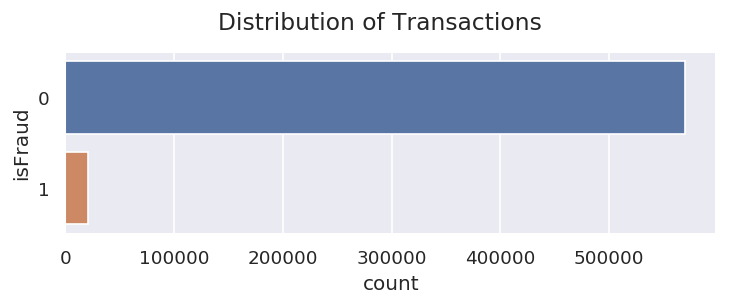

In [0]:
plt.figure(figsize=(7, 2), dpi=120)
plt.suptitle('Distribution of Transactions', size=14, y = 1.05)

ax = sns.countplot(data=train_raw_filtered, y=target_col)

plt.show()

In [0]:
train_positives = train_raw_filtered[train_raw_filtered[target_col] == 1]
train_negatives = train_raw_filtered[train_raw_filtered[target_col] == 0]

#### 1.2: Relative Distribution across Device-types

In [0]:
device_type_labels = train_raw_filtered['DeviceType'].unique()
print(device_type_labels)
print(train_positives.groupby(by='DeviceType').count()['TransactionID'])
print(train_negatives.groupby(by='DeviceType').count()['TransactionID'])

['UNK' 'mobile' 'desktop']
DeviceType
UNK        9452
desktop    5554
mobile     5657
Name: TransactionID, dtype: int64
DeviceType
UNK        440278
desktop     79611
mobile      49988
Name: TransactionID, dtype: int64


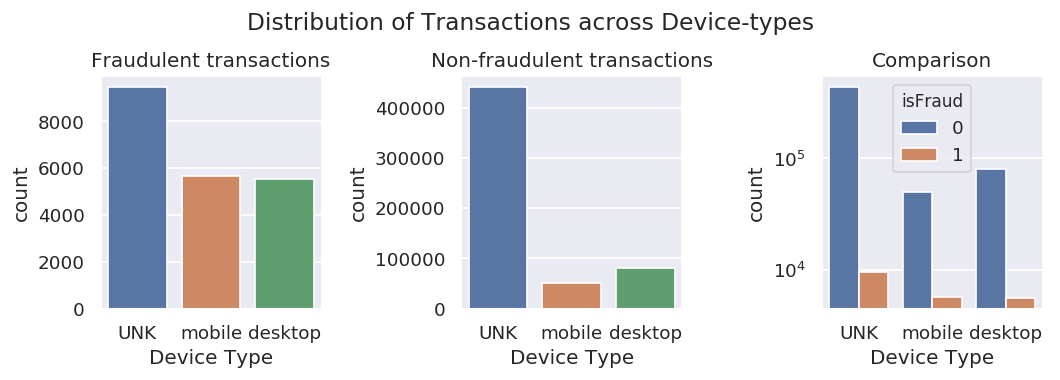

In [0]:
plt.figure(figsize=(9, 3), dpi=120)
plt.suptitle('Distribution of Transactions across Device-types', size=14, y = 1.05)

plt.subplot(131)
plt.title('Fraudulent transactions')
sns.countplot(data=train_positives, x='DeviceType', order=device_type_labels)
plt.xlabel('Device Type')

plt.subplot(132)
plt.title('Non-fraudulent transactions')
sns.countplot(data=train_negatives, x='DeviceType', order=device_type_labels)
plt.xlabel('Device Type')

plt.subplot(133)
plt.title('Comparison')
t = sns.countplot(data=train_raw_filtered, x='DeviceType', order=device_type_labels, hue=target_col)
t.set(yscale='log')
plt.xlabel('Device Type')

plt.tight_layout()
plt.show()

#### 1.3: Relative Distribution across Device-info (top ones only)

In [0]:
train_positives.groupby(by='DeviceInfo').count()['TransactionID'].nlargest()

DeviceInfo
UNK                       12056
Windows                    3121
iOS Device                 1240
MacOS                       278
hi6210sft Build/MRA58K      180
Name: TransactionID, dtype: int64

In [0]:
train_negatives.groupby(by='DeviceInfo').count()['TransactionID'].nlargest()

DeviceInfo
UNK            459818
Windows         44601
iOS Device      18542
MacOS           12295
Trident/7.0      7344
Name: TransactionID, dtype: int64

In [0]:
train_positives_tempDF = np.log(train_positives['DeviceInfo'].value_counts().head(4)).to_frame(name='log-fraud-count')
train_negatives_tempDF = np.log(train_negatives['DeviceInfo'].value_counts().head(4)).to_frame(name='log-non-fraud-count')

train_overall_tempDF = train_positives_tempDF.copy()
train_overall_tempDF['log-non-fraud-count'] = train_negatives_tempDF['log-non-fraud-count']

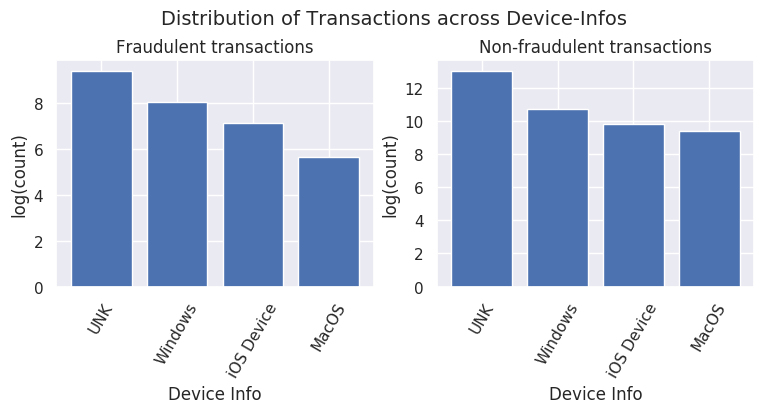

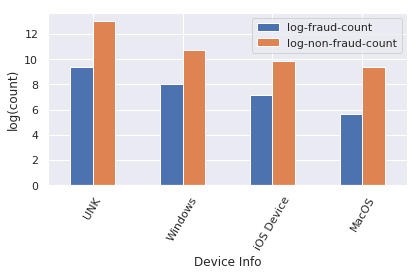

In [0]:
plt.figure(figsize=(9, 3), dpi=100)
plt.suptitle('Distribution of Transactions across Device-Infos', size=14, y = 1.05)

#fig, axes = plt.subplots(nrows=1, ncols=3)
plt.subplot(121)
plt.title('Fraudulent transactions')
plt.bar(train_positives_tempDF.index, train_positives_tempDF['log-fraud-count'])
plt.xlabel('Device Info')
plt.ylabel('log(count)')
plt.xticks(rotation=60)

plt.subplot(122)
plt.title('Non-fraudulent transactions')
plt.bar(train_negatives_tempDF.index, train_negatives_tempDF['log-non-fraud-count'])
plt.xlabel('Device Info')
plt.ylabel('log(count)')
plt.xticks(rotation=60)

train_overall_tempDF.plot(kind="bar")
plt.xlabel('Device Info')
plt.ylabel('log(count)')
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

#### 1.4: Distribution across Transaction Amounts

In [0]:
train_raw_filtered.describe()['TransactionAmt']

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

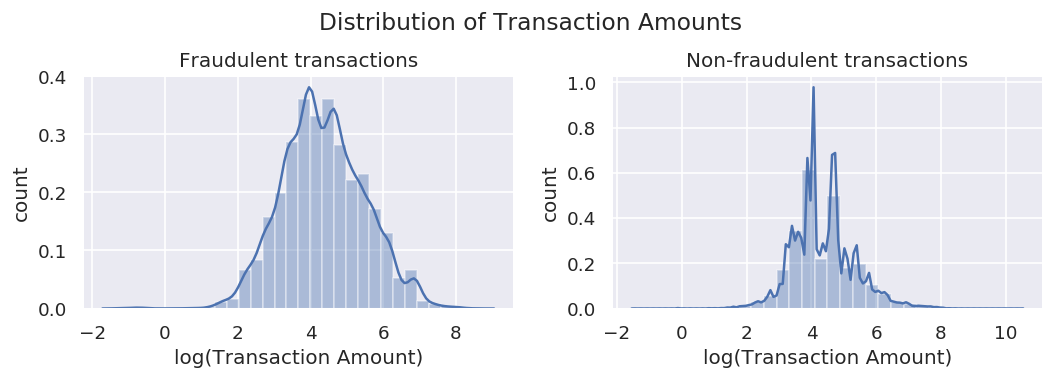

In [0]:
plt.figure(figsize=(9, 3), dpi=120)
plt.suptitle('Distribution of Transaction Amounts', size=14, y = 1.05)

plt.subplot(121)
plt.title('Fraudulent transactions')
ax = sns.distplot(np.log(train_positives['TransactionAmt']), bins=30)
ax.set_xlabel('log(Transaction Amount)')
ax.set_ylabel('count')

plt.subplot(122)
plt.title('Non-fraudulent transactions')
ax = sns.distplot(np.log(train_negatives['TransactionAmt']), bins=30)
ax.set_xlabel('log(Transaction Amount)')
ax.set_ylabel('count')

plt.tight_layout()
plt.show()

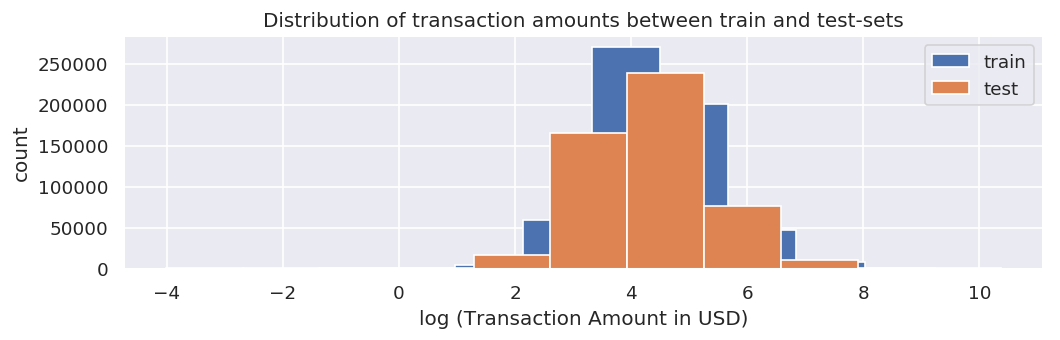

In [0]:
fig = plt.figure(figsize=(9,3), dpi=120)

plt.title('Distribution of transaction amounts between train and test-sets')
plt.hist(np.log(train_raw['TransactionAmt']), label='train')
plt.hist(np.log(test_raw['TransactionAmt']), label='test')
plt.xlabel('log (Transaction Amount in USD)')
plt.ylabel('count')
plt.legend();

plt.tight_layout()
plt.show()

#### 1.5: Distribution across Time (from starting reference point)

In [0]:
train_raw_filtered.describe()['TransactionDT']//3600

count     164.0
mean     2047.0
std      1282.0
min        24.0
25%       840.0
50%      2029.0
75%      3124.0
max      4391.0
Name: TransactionDT, dtype: float64

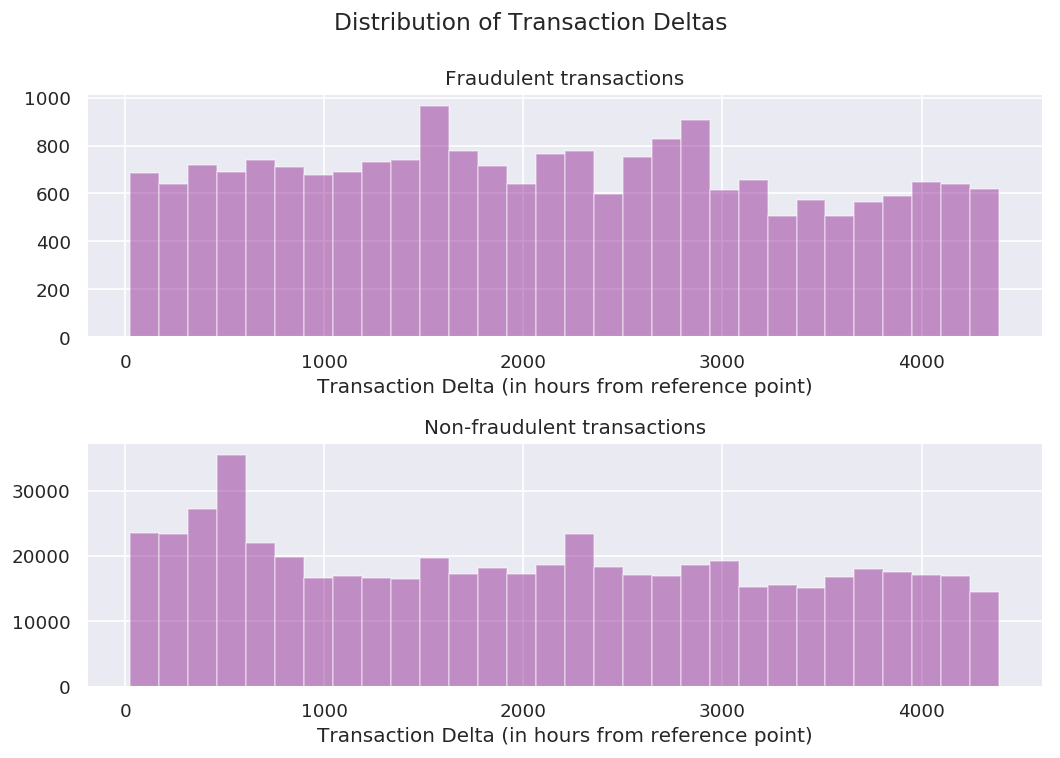

In [0]:
plt.figure(figsize=(9, 6), dpi=120)
plt.suptitle('Distribution of Transaction Deltas', size=14, y = 1.05)

plt.subplot(211)
plt.title('Fraudulent transactions')
ax = sns.distplot((train_positives['TransactionDT']//3600), kde=False, bins=30, color='purple')
ax.set_xlabel('Transaction Delta (in hours from reference point)')

plt.subplot(212)
plt.title('Non-fraudulent transactions')
ax = sns.distplot((train_negatives['TransactionDT']//3600), kde=False, bins=30, color='purple')
ax.set_xlabel('Transaction Delta (in hours from reference point)')

plt.tight_layout()
plt.show()

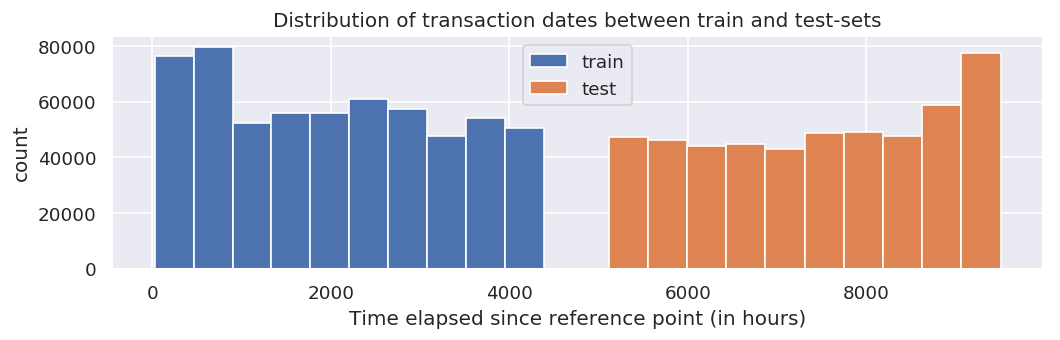

In [0]:
fig = plt.figure(figsize=(9,3), dpi=120)

plt.title('Distribution of transaction dates between train and test-sets')
plt.hist(train_raw['TransactionDT']/3600, label='train')
plt.hist(test_raw['TransactionDT']/3600, label='test')
plt.xlabel('Time elapsed since reference point (in hours)')
plt.ylabel('count')
plt.legend();

plt.tight_layout()
plt.show()

#### 1.6: Distribution across Product codes

In [0]:
product_code_labels = train_raw_filtered['ProductCD'].unique()
print(product_code_labels)
print(train_positives.groupby(by='ProductCD').count()['TransactionID'])
print(train_negatives.groupby(by='ProductCD').count()['TransactionID'])

['W' 'H' 'C' 'S' 'R']
ProductCD
C    8008
H    1574
R    1426
S     686
W    8969
Name: TransactionID, dtype: int64
ProductCD
C     60511
H     31450
R     36273
S     10942
W    430701
Name: TransactionID, dtype: int64


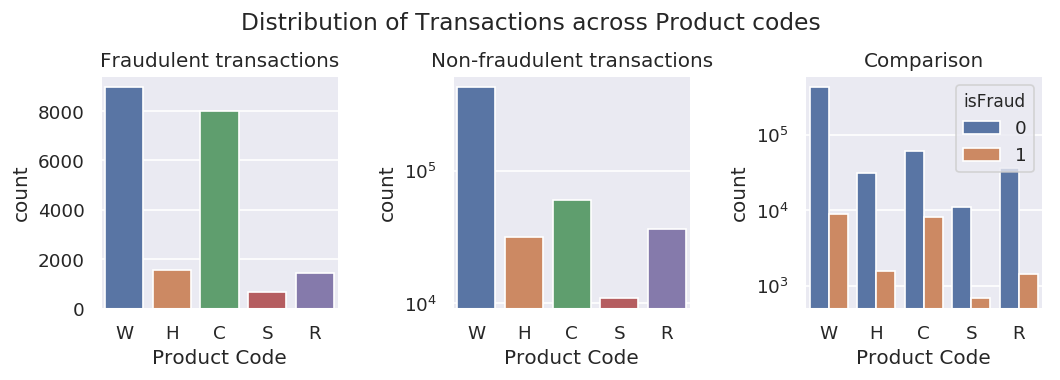

In [0]:
plt.figure(figsize=(9, 3), dpi=120)
plt.suptitle('Distribution of Transactions across Product codes', size=14, y = 1.05)

plt.subplot(131)
plt.title('Fraudulent transactions')
sns.countplot(data=train_positives, x='ProductCD', order=product_code_labels)
plt.xlabel('Product Code')

plt.subplot(132)
plt.title('Non-fraudulent transactions')
n = sns.countplot(data=train_negatives, x='ProductCD', order=product_code_labels)
n.set(yscale='log')
plt.xlabel('Product Code')

plt.subplot(133)
plt.title('Comparison')
t = sns.countplot(data=train_raw_filtered, x='ProductCD', order=product_code_labels, hue=target_col)
t.set(yscale='log')
plt.xlabel('Product Code')

plt.tight_layout()
plt.show()

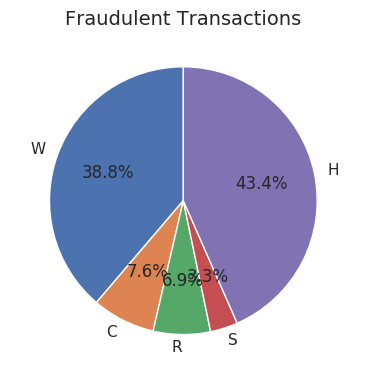

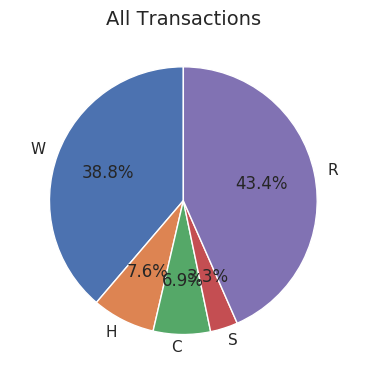

In [0]:
plt.figure(figsize = (9, 4), dpi = 100)
plt.title("Fraudulent Transactions", size=14)
ax = plt.pie(x=train_positives[target_col].groupby(train_positives['ProductCD']).sum(), labels=train_positives['ProductCD'].unique(),
            autopct='%1.1f%%', startangle=90)
plt.tight_layout()
plt.show()

plt.figure(figsize = (9, 4), dpi = 100)
plt.title("All Transactions", size=14)
ax = plt.pie(x=train_raw_filtered[target_col].groupby(train_raw_filtered['ProductCD']).sum(), labels=train_raw_filtered['ProductCD'].unique(),
            autopct='%1.1f%%', startangle=90)

plt.tight_layout()
plt.show()

#### 1.7: Distribution across Card-issuers

In [0]:
card_issuer_labels = train_raw_filtered['card4'].unique()
print(card_issuer_labels)
print(train_positives.groupby(by='card4').count()['TransactionID'])
print(train_negatives.groupby(by='card4').count()['TransactionID'])

['discover' 'mastercard' 'visa' 'american express' 'UNK']
card4
UNK                    41
american express      239
discover              514
mastercard           6496
visa                13373
Name: TransactionID, dtype: int64
card4
UNK                   1536
american express      8089
discover              6137
mastercard          182721
visa                371394
Name: TransactionID, dtype: int64


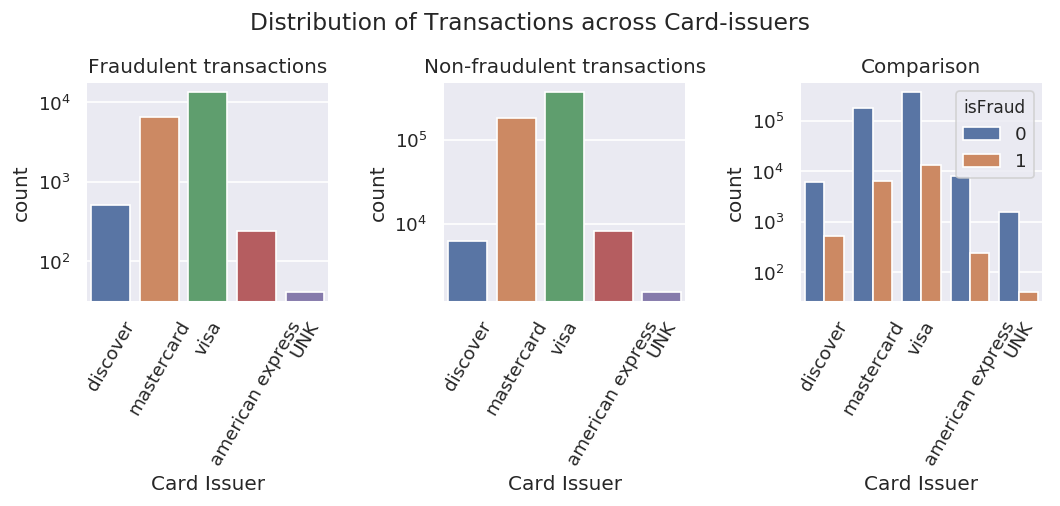

In [0]:
plt.figure(figsize=(9, 4), dpi=120)
plt.suptitle('Distribution of Transactions across Card-issuers', size=14, y = 1.05)

plt.subplot(131)
plt.title('Fraudulent transactions')
p = sns.countplot(data=train_positives, x='card4', order=card_issuer_labels)
p.set(yscale='log')
plt.xlabel('Card Issuer')
plt.xticks(rotation=60)

plt.subplot(132)
plt.title('Non-fraudulent transactions')
n = sns.countplot(data=train_negatives, x='card4', order=card_issuer_labels)
n.set(yscale='log')
plt.xlabel('Card Issuer')
plt.xticks(rotation=60)

plt.subplot(133)
plt.title('Comparison')
t = sns.countplot(data=train_raw_filtered, x='card4', order=card_issuer_labels, hue=target_col)
t.set(yscale='log')
plt.xlabel('Card Issuer')
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

#### 1.8: Distribution across Card-types

In [0]:
card_type_labels = train_raw_filtered['card6'].unique()
print(card_type_labels)
print(train_positives.groupby(by='card6').count()['TransactionID'])
print(train_negatives.groupby(by='card6').count()['TransactionID'])

['credit' 'debit' 'UNK' 'debit or credit' 'charge card']
card6
UNK          39
credit     9950
debit     10674
Name: TransactionID, dtype: int64
card6
UNK                  1532
charge card            15
credit             139036
debit              429264
debit or credit        30
Name: TransactionID, dtype: int64


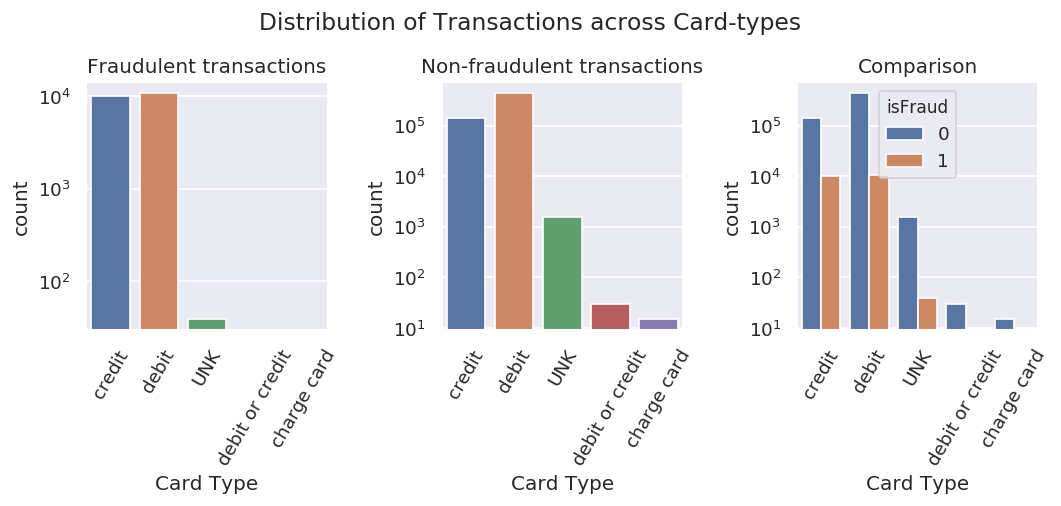

In [0]:
plt.figure(figsize=(9, 4), dpi=120)
plt.suptitle('Distribution of Transactions across Card-types', size=14, y = 1.05)

plt.subplot(131)
plt.title('Fraudulent transactions')
p = sns.countplot(data=train_positives, x='card6', order=card_type_labels)
p.set(yscale='log')
plt.xlabel('Card Type')
plt.xticks(rotation=60)

plt.subplot(132)
plt.title('Non-fraudulent transactions')
n = sns.countplot(data=train_negatives, x='card6', order=card_type_labels)
n.set(yscale='log')
plt.xlabel('Card Type')
plt.xticks(rotation=60)

plt.subplot(133)
plt.title('Comparison')
t = sns.countplot(data=train_raw_filtered, x='card6', order=card_type_labels, hue=target_col)
t.set(yscale='log')
plt.xlabel('Card Type')
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

#### 1.9: Distribution across Purchaser Email domains (top ones only)

In [0]:
P_emaildomain_labels = train_raw_filtered['P_emaildomain'].unique()
print(P_emaildomain_labels)
print(train_positives.groupby(by='P_emaildomain').count()['TransactionID'])
print(train_negatives.groupby(by='P_emaildomain').count()['TransactionID'])

In [0]:
train_positives_tempDF = np.log(train_positives['P_emaildomain'].value_counts().head(9)).to_frame(name='log-fraud-count')
train_positives_tempDF['P_emaildomain'] = train_positives_tempDF.index
train_negatives_tempDF = np.log(train_negatives['P_emaildomain'].value_counts().head(9)).to_frame(name='log-non-fraud-count')
train_negatives_tempDF['P_emaildomain'] = train_negatives_tempDF.index

train_overall_tempDF = train_negatives_tempDF.merge(train_positives_tempDF, on='P_emaildomain', how='left')
train_overall_tempDF.index = train_overall_tempDF['P_emaildomain']
del train_overall_tempDF['P_emaildomain']

In [0]:
train_overall_tempDF

,log-non-fraud-count,log-fraud-count
P_emaildomain,,
gmail.com,12.294138,9.204624
yahoo.com,11.499202,7.739359
UNK,11.425907,7.933797
hotmail.com,10.665554,7.781556
anonymous.com,10.495128,6.755769
aol.com,10.228176,6.424869
comcast.net,8.941415,5.505332
icloud.com,8.711114,5.283204
outlook.com,8.436850,6.177944


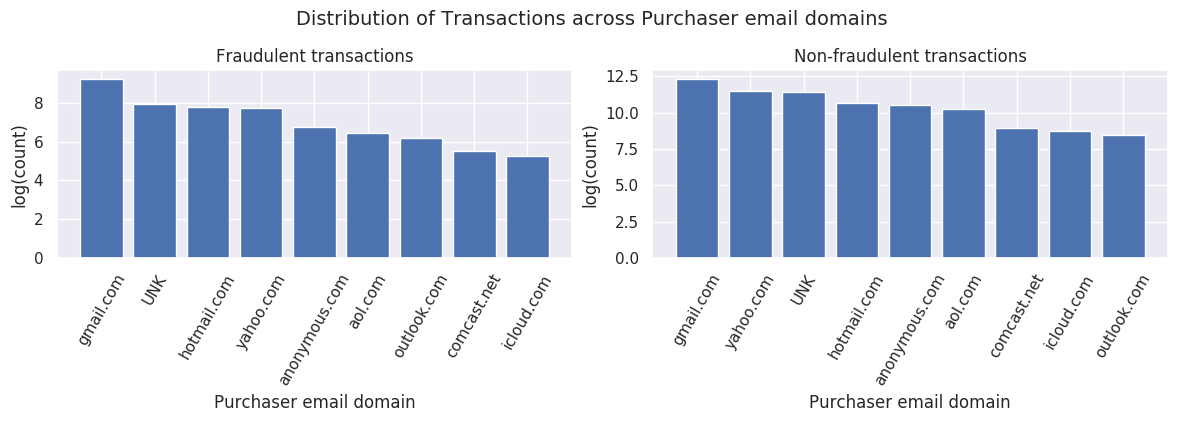

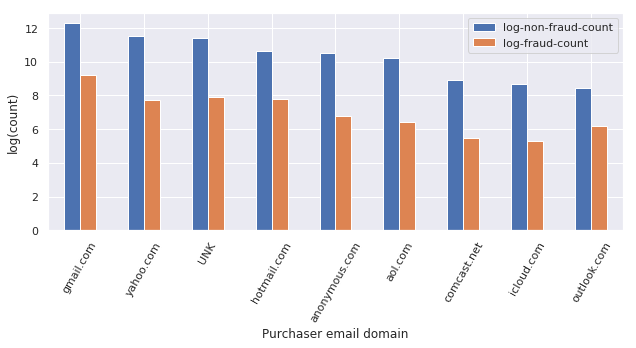

In [0]:
plt.figure(figsize=(12, 4), dpi=100)
plt.suptitle('Distribution of Transactions across Purchaser email domains', size=14, y = 1.05)

plt.subplot(121)
plt.title('Fraudulent transactions')
plt.bar(train_positives_tempDF['P_emaildomain'], train_positives_tempDF['log-fraud-count'])
plt.xlabel('Purchaser email domain')
plt.ylabel('log(count)')
plt.xticks(rotation=60)

plt.subplot(122)
plt.title('Non-fraudulent transactions')
plt.bar(train_negatives_tempDF['P_emaildomain'], train_negatives_tempDF['log-non-fraud-count'])
plt.xlabel('Purchaser email domain')
plt.ylabel('log(count)')
plt.xticks(rotation=60)

plt.tight_layout()

train_overall_tempDF.plot(kind="bar", figsize=(9, 5))
plt.xlabel('Purchaser email domain')
plt.ylabel('log(count)')
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

#### 1.10: Distribution across Receiver Email domain (top ones only)

In [0]:
R_emaildomain_labels = train_raw_filtered['R_emaildomain'].unique()
print(R_emaildomain_labels)
print(train_positives.groupby(by='R_emaildomain').count()['TransactionID'])
print(train_negatives.groupby(by='R_emaildomain').count()['TransactionID'])

In [0]:
train_positives_tempDF = np.log(train_positives['R_emaildomain'].value_counts().head(20)).to_frame(name='log-fraud-count')
train_positives_tempDF['R_emaildomain'] = train_positives_tempDF.index
train_negatives_tempDF = np.log(train_negatives['R_emaildomain'].value_counts().head(20)).to_frame(name='log-non-fraud-count')
train_negatives_tempDF['R_emaildomain'] = train_negatives_tempDF.index

train_overall_tempDF = train_negatives_tempDF.merge(train_positives_tempDF, on='R_emaildomain', how='left')
train_overall_tempDF.index = train_overall_tempDF['R_emaildomain']
del train_overall_tempDF['R_emaildomain']

In [0]:
train_overall_tempDF

,log-non-fraud-count,log-fraud-count
R_emaildomain,,
UNK,13.003159,9.152287
gmail.com,10.826476,8.826294
hotmail.com,10.141283,7.668561
anonymous.com,9.900032,6.393591
yahoo.com,9.326522,6.413459
aol.com,8.180881,4.859812
outlook.com,7.646354,6.025866
comcast.net,7.490529,3.044522
yahoo.com.mx,7.307873,2.772589


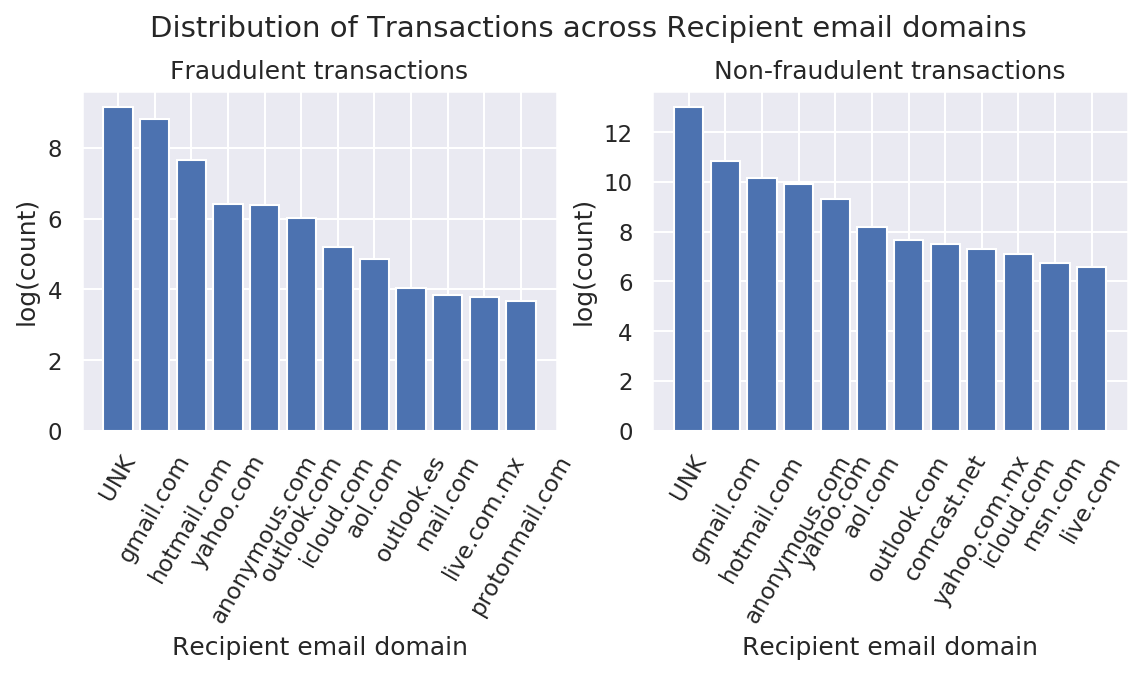

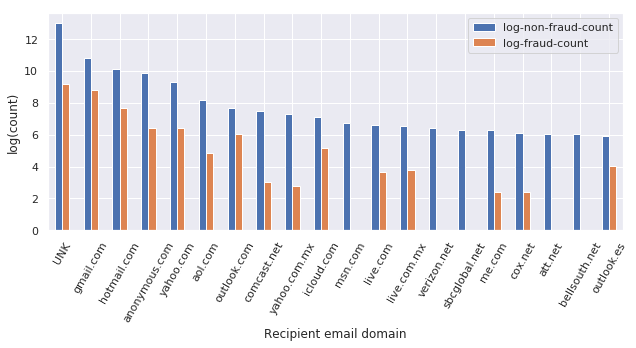

In [0]:
plt.figure(figsize=(9, 3), dpi=150)
plt.suptitle('Distribution of Transactions across Recipient email domains', size=14, y = 1.05)

plt.subplot(121)
plt.title('Fraudulent transactions')
plt.bar(train_positives_tempDF['R_emaildomain'].head(12), train_positives_tempDF['log-fraud-count'].head(12))
plt.xlabel('Recipient email domain')
plt.ylabel('log(count)')
plt.xticks(rotation=60)

plt.subplot(122)
plt.title('Non-fraudulent transactions')
plt.bar(train_negatives_tempDF['R_emaildomain'].head(12), train_negatives_tempDF['log-non-fraud-count'].head(12))
plt.xlabel('Recipient email domain')
plt.ylabel('log(count)')
plt.xticks(rotation=60)

train_overall_tempDF.plot(kind="bar", figsize=(9, 5))
plt.xlabel('Recipient email domain')
plt.ylabel('log(count)')
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

#### 1.11: Distribution across Address code 1

In [0]:
addr1_labels = train_raw_filtered['addr1'].unique()
print(addr1_labels)

[315.0 325.0 330.0 476.0 420.0 272.0 126.0 337.0 204.0 'UNK' 226.0 170.0
 184.0 264.0 299.0 441.0 472.0 251.0 469.0 191.0 485.0 122.0 220.0 205.0
 387.0 181.0 231.0 436.0 327.0 343.0 123.0 502.0 269.0 158.0 433.0 143.0
 225.0 492.0 177.0 512.0 310.0 308.0 418.0 494.0 253.0 428.0 203.0 110.0
 444.0 498.0 194.0 536.0 384.0 324.0 295.0 448.0 157.0 171.0 224.0 491.0
 274.0 432.0 459.0 106.0 296.0 254.0 452.0 347.0 335.0 305.0 161.0 221.0
 154.0 130.0 465.0 451.0 331.0 511.0 486.0 312.0 242.0 131.0 508.0 332.0
 283.0 216.0 431.0 391.0 333.0 496.0 304.0 167.0 261.0 399.0 164.0 142.0
 393.0 258.0 375.0 483.0 404.0 482.0 148.0 218.0 127.0 403.0 374.0 477.0
 478.0 241.0 504.0 453.0 535.0 100.0 239.0 152.0 500.0 356.0 198.0 162.0
 244.0 520.0 531.0 401.0 427.0 352.0 540.0 456.0 371.0 409.0 529.0 505.0
 503.0 346.0 359.0 499.0 298.0 190.0 454.0 172.0 145.0 493.0 119.0 521.0
 270.0 395.0 366.0 348.0 313.0 338.0 139.0 443.0 183.0 430.0 102.0 470.0
 133.0 233.0 468.0 185.0 523.0 411.0 501.0 425.0 42

In [0]:
# Assign proper data-type after examining the distinct values from all the unique values as seen above

# 'UNK' can't be converted to int32, so temporarily replacing it with an integer absent in the data otherwise
train_raw_filtered['addr1'].replace('UNK', -1, inplace=True)
train_raw_filtered = train_raw_filtered.astype({'addr1':'int32'})
train_positives = train_raw_filtered[train_raw_filtered[target_col] == 1]
train_negatives = train_raw_filtered[train_raw_filtered[target_col] == 0]

# Reset the -1's back to UNK
train_raw_filtered['addr1'].replace(-1, 'UNK', inplace=True)
train_positives['addr1'].replace(-1, 'UNK', inplace=True)
train_negatives['addr1'].replace(-1, 'UNK', inplace=True)

addr1_labels = train_raw_filtered.groupby('addr1').count()['TransactionID'].sort_values(ascending=False).index
print(addr1_labels)
print(train_positives.groupby('addr1').count()['TransactionID'].sort_values(ascending=False).head(10))
print(train_negatives.groupby('addr1').count()['TransactionID'].sort_values(ascending=False).head(10))

Index(['UNK',   299,   325,   204,   264,   330,   315,   441,   272,   123,
       ...
         217,   328,   219,   326,   223,   530,   493,   467,   227,   262],
      dtype='object', name='addr1', length=333)
addr1
UNK    7741
204    1120
325    1087
299     985
330     840
264     728
272     576
441     533
337     439
315     411
Name: TransactionID, dtype: int64
addr1
UNK    57965
299    45350
325    41664
204    40900
264    39142
330    25447
315    22667
441    20294
272    19565
123    15707
Name: TransactionID, dtype: int64


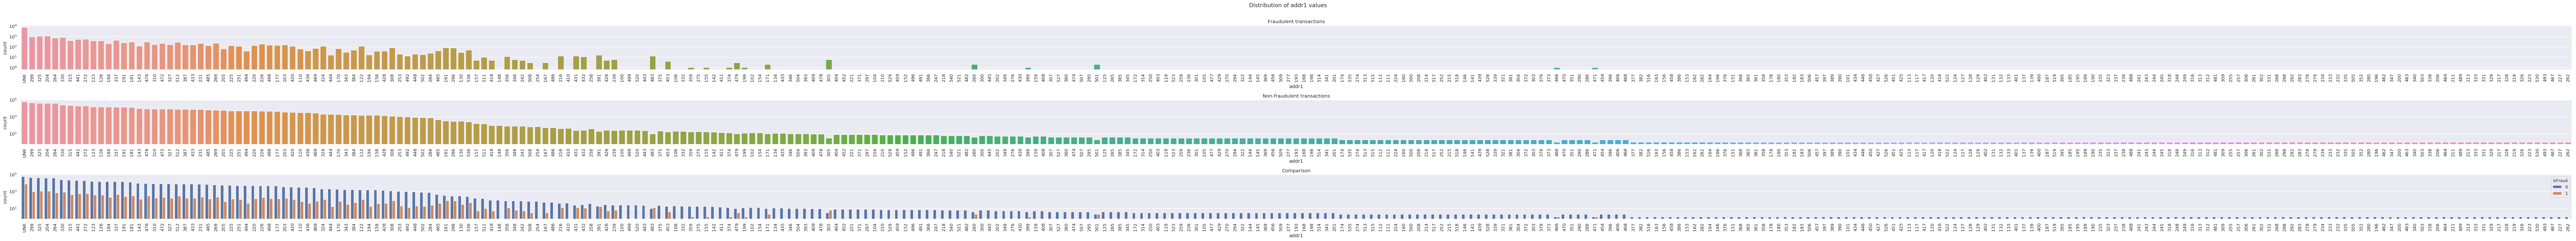

In [0]:
plt.figure(figsize=(90, 8), dpi=120)
plt.suptitle('Distribution of addr1 values', size=14, y = 1.05)

plt.subplot(311)
plt.title('Fraudulent transactions')
p = sns.countplot(data=train_positives, x='addr1', order=addr1_labels)
p.set(yscale='log')
plt.xticks(rotation=90)

plt.subplot(312)
plt.title('Non-fraudulent transactions')
n = sns.countplot(data=train_negatives, x='addr1', order=addr1_labels)
n.set(yscale='log')
plt.xticks(rotation=90)

plt.subplot(313)
plt.title('Comparison')
t = sns.countplot(data=train_raw_filtered, x='addr1', order=addr1_labels, hue=target_col)
t.set(yscale='log')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

#### 1.12: Distribution across Address code 2

In [0]:
addr2_labels = train_raw_filtered['addr2'].unique()
print(addr2_labels)

[87.0 'UNK' 96.0 35.0 60.0 98.0 43.0 65.0 32.0 13.0 31.0 101.0 24.0 16.0
 15.0 19.0 71.0 59.0 102.0 44.0 26.0 69.0 47.0 78.0 88.0 66.0 72.0 22.0
 57.0 25.0 17.0 30.0 29.0 21.0 14.0 49.0 83.0 75.0 34.0 86.0 48.0 68.0
 23.0 70.0 62.0 54.0 50.0 52.0 39.0 76.0 10.0 73.0 97.0 63.0 27.0 28.0
 38.0 74.0 77.0 92.0 79.0 84.0 82.0 40.0 36.0 46.0 18.0 20.0 89.0 61.0
 94.0 100.0 55.0 51.0 93.0]


In [0]:
# Assign proper data-type after examining the distinct values from all the unique values as seen above

# 'UNK' can't be converted to int32, so temporarily replacing it with an integer absent in the data otherwise
train_raw_filtered['addr2'].replace('UNK', -1, inplace=True)
train_raw_filtered = train_raw_filtered.astype({'addr2':'int32'})
train_positives = train_raw_filtered[train_raw_filtered[target_col] == 1]
train_negatives = train_raw_filtered[train_raw_filtered[target_col] == 0]

# Reset the -1's back to UNK
train_raw_filtered['addr2'].replace(-1, 'UNK', inplace=True)
train_positives['addr2'].replace(-1, 'UNK', inplace=True)
train_negatives['addr2'].replace(-1, 'UNK', inplace=True)

addr2_labels = train_raw_filtered.groupby('addr2').count()['TransactionID'].sort_values(ascending=False).index
print(addr2_labels)
print(train_positives.groupby('addr2').count()['TransactionID'].sort_values(ascending=False).head(10))
print(train_negatives.groupby('addr2').count()['TransactionID'].sort_values(ascending=False).head(10))

Index([   87, 'UNK',    60,    96,    32,    65,    16,    31,    19,    26,
          27,    69,    59,    34,    43,    98,    29,   102,    57,    68,
          10,    78,    17,    71,    13,    72,    54,    52,    21,    88,
          73,    48,    62,    28,   101,    47,    51,    30,    74,    44,
          46,    39,    40,    20,    18,    61,    24,    38,    36,    92,
          23,   100,    86,    63,    66,    76,    97,    25,    22,    15,
          14,    75,    94,    93,    89,    35,    49,    50,    84,    83,
          82,    79,    77,    70,    55],
      dtype='object', name='addr2')
addr2
87     12477
UNK     7741
60       279
96        89
65        44
10         8
32         6
51         4
46         3
92         2
Name: TransactionID, dtype: int64
addr2
87     508004
UNK     57965
60       2805
96        549
32         85
16         55
31         47
65         38
19         33
26         25
Name: TransactionID, dtype: int64


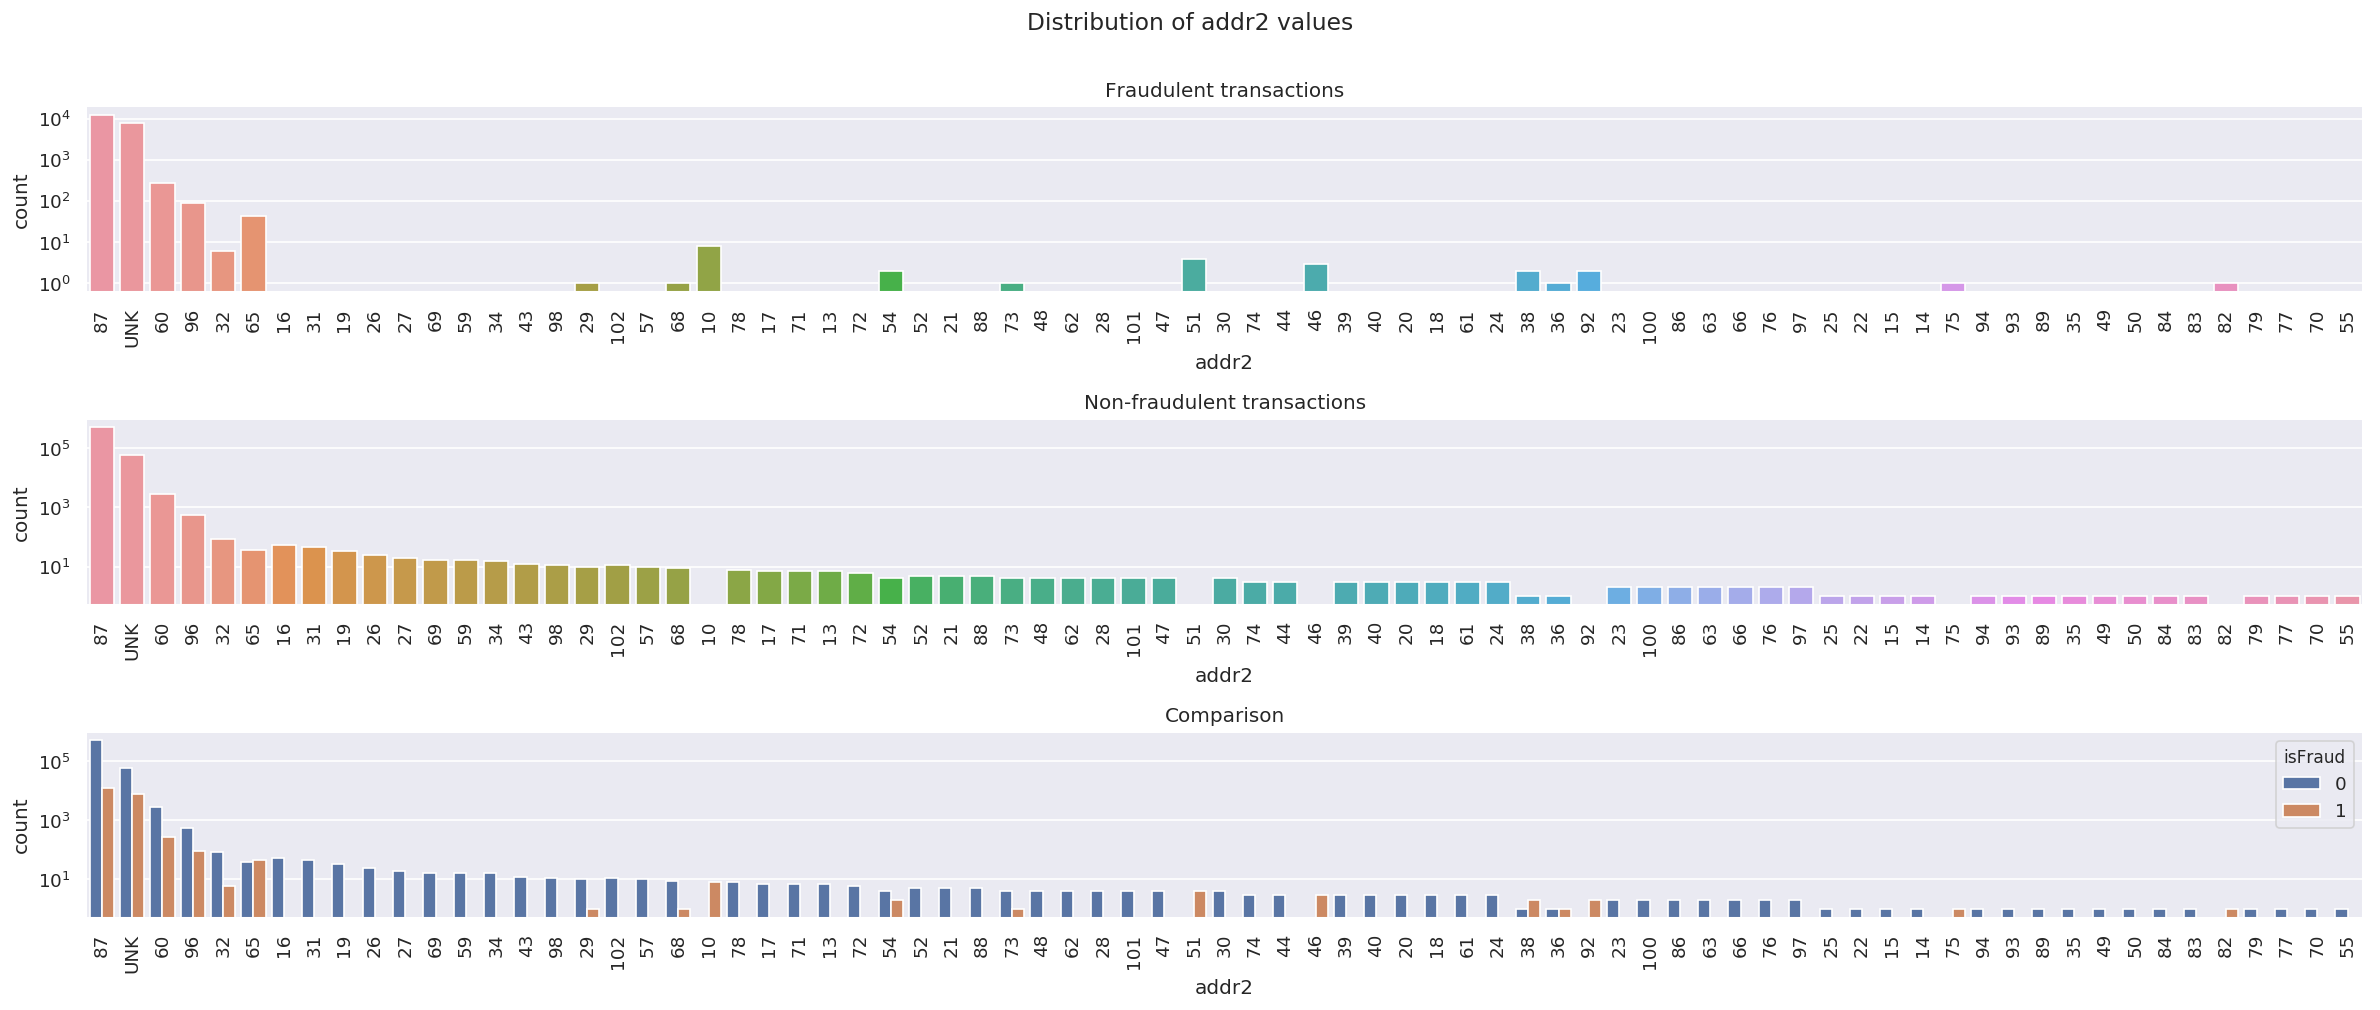

In [0]:
plt.figure(figsize=(20, 8), dpi=120)
plt.suptitle('Distribution of addr2 values', size=14, y = 1.05)

plt.subplot(311)
plt.title('Fraudulent transactions')
p = sns.countplot(data=train_positives, x='addr2', order=addr2_labels)
p.set(yscale='log')
plt.xticks(rotation=90)

plt.subplot(312)
plt.title('Non-fraudulent transactions')
n = sns.countplot(data=train_negatives, x='addr2', order=addr2_labels)
n.set(yscale='log')
plt.xticks(rotation=90)

plt.subplot(313)
plt.title('Comparison')
t = sns.countplot(data=train_raw_filtered, x='addr2', order=addr2_labels, hue=target_col)
t.set(yscale='log')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [0]:
only_fraud_addr2s = [label for label in addr2_labels if label not in train_negatives['addr2'].unique() and label in train_positives['addr2'].unique()]
print(only_fraud_addr2s)
train_positives[train_positives['addr2'].isin(only_fraud_addr2s)].groupby('addr2').count()['TransactionID']

[10, 51, 46, 92, 75, 82]


addr2
10    8
46    3
51    4
75    1
82    1
92    2
Name: TransactionID, dtype: int64

#### 1.13: Distribution across Distance code 1

In [0]:
print(len(train_raw_filtered['dist1'].unique()))

2652


In [0]:
# Drop 'UNK' temporarily to get descriptive stats and plot distribution for numeric variable
train_raw_filtered_tempDF = train_raw_filtered[['dist1', target_col]].replace('UNK', np.nan)
train_raw_filtered_tempDF.dropna(inplace=True)
print(train_raw_filtered_tempDF.describe())
train_positives_tempDF = train_raw_filtered_tempDF[train_raw_filtered_tempDF[target_col] == 1]
print(train_positives_tempDF.describe()['dist1'])
train_negatives_tempDF = train_raw_filtered_tempDF[train_raw_filtered_tempDF[target_col] == 0]
print(train_negatives_tempDF.describe()['dist1'])

               dist1        isFraud
count  238269.000000  238269.000000
mean      118.502180       0.019956
std       371.872026       0.139851
min         0.000000       0.000000
25%         3.000000       0.000000
50%         8.000000       0.000000
75%        24.000000       0.000000
max     10286.000000       1.000000
count    4755.000000
mean      174.588854
std       424.232313
min         0.000000
25%         3.000000
50%        10.000000
75%        85.500000
max      4942.000000
Name: dist1, dtype: float64
count    233514.000000
mean        117.360098
std         370.641879
min           0.000000
25%           3.000000
50%           8.000000
75%          24.000000
max       10286.000000
Name: dist1, dtype: float64


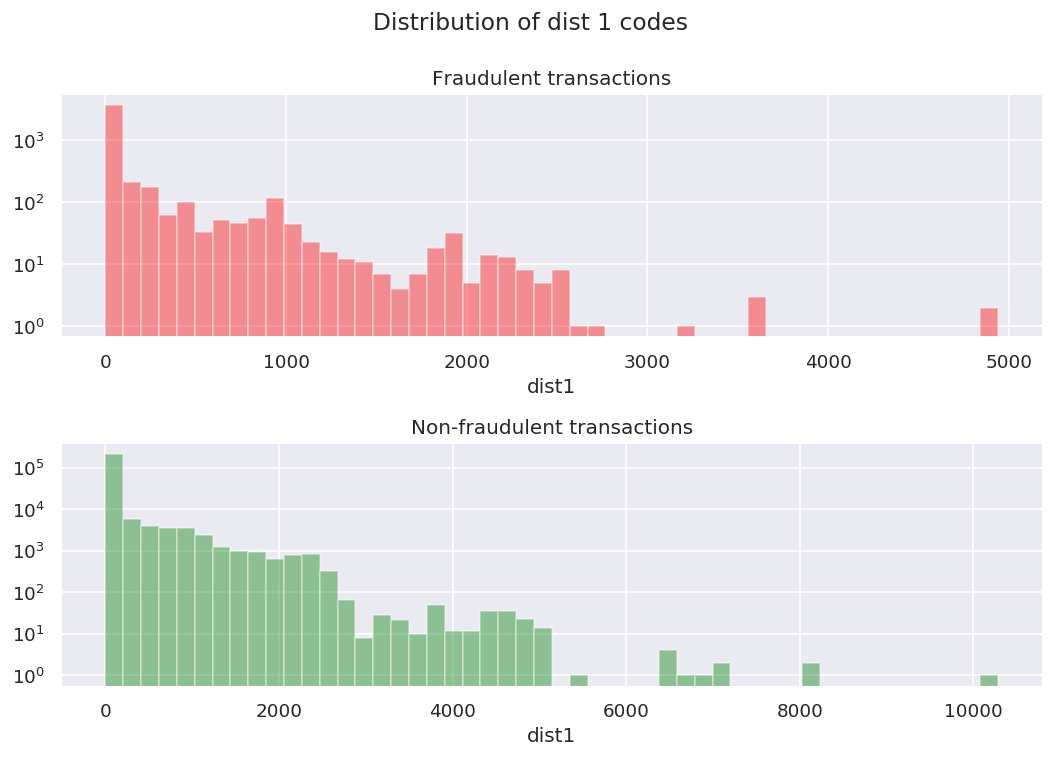

In [0]:
plt.figure(figsize=(9, 6), dpi=120)
plt.suptitle('Distribution of dist 1 codes', size=14, y = 1.05)

plt.subplot(211)
plt.title('Fraudulent transactions')
ax = sns.distplot(train_positives_tempDF['dist1'], kde=False, color='red')
ax.set(yscale="log")

plt.subplot(212)
plt.title('Non-fraudulent transactions')
ax = sns.distplot(train_negatives_tempDF['dist1'], kde=False, color='green')
ax.set(yscale="log")

plt.tight_layout()
plt.show()

#### 1.14: Distribution across Distance code 2

In [0]:
print(len(train_raw_filtered['dist2'].unique()))

1752


In [0]:
# Drop 'UNK' temporarily to get descriptive stats and plot distribution for numeric variable
train_raw_filtered_tempDF = train_raw_filtered[['dist2', target_col]].replace('UNK', np.nan)
train_raw_filtered_tempDF.dropna(inplace=True)
print(train_raw_filtered_tempDF.describe())
train_positives_tempDF = train_raw_filtered_tempDF[train_raw_filtered_tempDF[target_col] == 1]
print(train_positives_tempDF.describe()['dist2'])
train_negatives_tempDF = train_raw_filtered_tempDF[train_raw_filtered_tempDF[target_col] == 0]
print(train_negatives_tempDF.describe()['dist2'])

              dist2       isFraud
count  37627.000000  37627.000000
mean     231.855423      0.099158
std      529.053494      0.298877
min        0.000000      0.000000
25%        7.000000      0.000000
50%       37.000000      0.000000
75%      206.000000      0.000000
max    11623.000000      1.000000
count    3731.000000
mean      201.472259
std       451.589576
min         0.000000
25%         7.000000
50%        49.000000
75%       233.000000
max      9337.000000
Name: dist2, dtype: float64
count    33896.000000
mean       235.199758
std        536.798492
min          0.000000
25%          7.000000
50%         36.000000
75%        206.000000
max      11623.000000
Name: dist2, dtype: float64


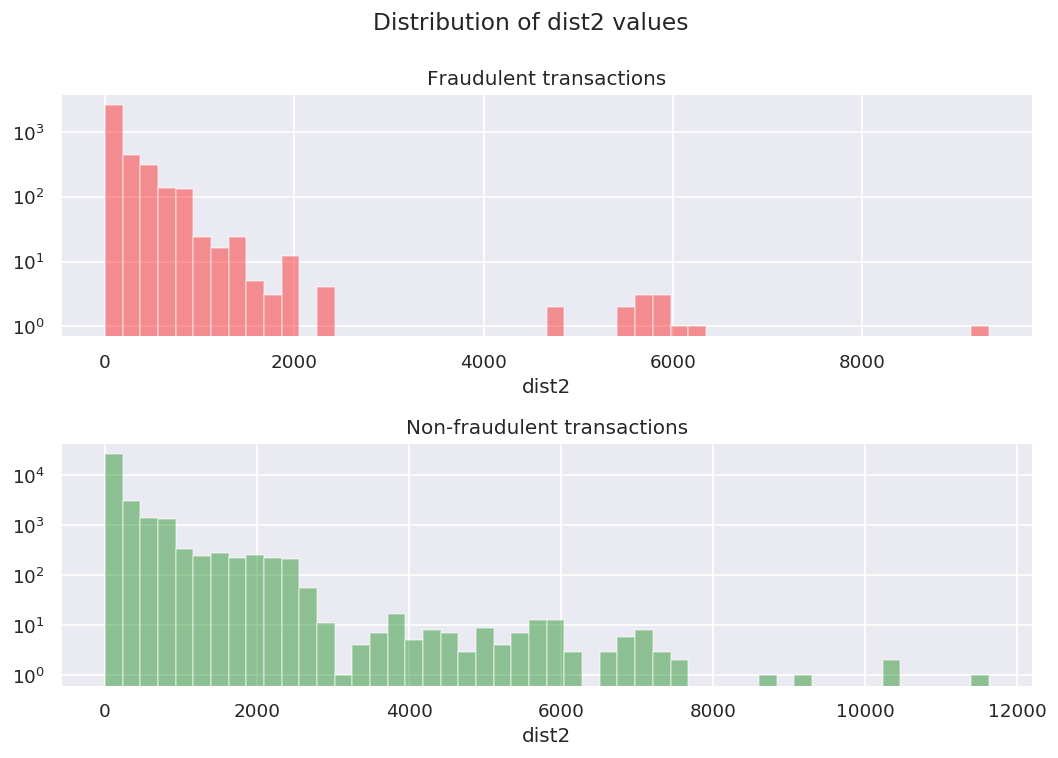

In [0]:
plt.figure(figsize=(9, 6), dpi=120)
plt.suptitle('Distribution of dist2 values', size=14, y = 1.05)

plt.subplot(211)
plt.title('Fraudulent transactions')
ax = sns.distplot(train_positives_tempDF['dist2'], kde=False, color='red')
ax.set(yscale="log")

plt.subplot(212)
plt.title('Non-fraudulent transactions')
ax = sns.distplot(train_negatives_tempDF['dist2'], kde=False, color='green')
ax.set(yscale="log")

plt.tight_layout()
plt.show()

### Key Observations from initial exploration:

1. **Many of these fields follow power-law distribution** - Many fields like Transaction Amount, addr2 codes, Device-info, etc. follow power-law distributions. To avoid the skew, the values have been plotted in logarithmic scale and/or transformed using logarithms.
2. **Training data and Test data have no overlap in time** - In the 3rd plot of transaction frequency distribution across time (Plot 1.5), both test and training data were plotted and the distributions for training and test data were completely disjoint.
3. **The average transaction amount for the Test data is more than that of the training data** - as visible in the Distribution of transactions across Transaction amounts (Plot 1.4 - part 2)
4. **Fraudulent transactions tend to charge more money** - In the plots of transaction distribution across amounts (Plot 1.4), it can be seen that the average fraudulent transaction tend to be higher-amount transaction than the average non-fraudulent counterpart.
5. **Though product code C has fewest transactions, it has the highest number of fraudulent transactions** - In the distribution across product-code pie-plot (Plot 1.6), we can see that product-code C occupies more area in the fraudulent transactions pie-chart compared to that of the overall transactions.
6. **Some addr2 values have only fraudulent transactions!** - In the transaction frequency distribution across addr2-codes (Plot 1.12), it can be noticed that some addr2 codes are not absent from the 2nd plot (non-fraudulent transactions), but present in the first. If addr2 codes map to region/country codes, then that means that **only fraudulent transactions were generated from those regions during the time the data was collected**.

## Part 2 - Transaction Frequency

In [0]:
# 'UNK' can't be converted to int32, so temporarily replacing it with an integer absent in the data otherwise
train_raw_filtered['addr2'].replace('UNK', -1, inplace=True)
train_raw_filtered = train_raw_filtered.astype({'addr2':'int32'})

most_freq_addr2 = train_raw_filtered.groupby('addr2').count()[target_col].idxmax()
print("Most frequent addr2:", most_freq_addr2)

# Reset the -1's back to UNK
train_raw_filtered['addr2'].replace(-1, 'UNK', inplace=True)

Most frequent addr2: 87


In [0]:
train_raw_filtered_pt2 = train_raw_filtered[train_raw_filtered['addr2'] == most_freq_addr2][[target_col, 'TransactionDT']]
train_raw_filtered_pt2['TransactionDT_hr'] = train_raw_filtered_pt2['TransactionDT'] // 3600
# min_timeDT = train_raw_filtered_pt2['TransactionDT'].min()
# print(min_timeDT)
train_raw_filtered_pt2['Transaction_hrOfDay'] = train_raw_filtered_pt2['TransactionDT_hr'] % 24
train_raw_filtered_pt2.head()

,isFraud,TransactionDT,TransactionDT_hr,Transaction_hrOfDay
0,0,86400,24,0
1,0,86401,24,0
2,0,86469,24,0
3,0,86499,24,0
4,0,86506,24,0


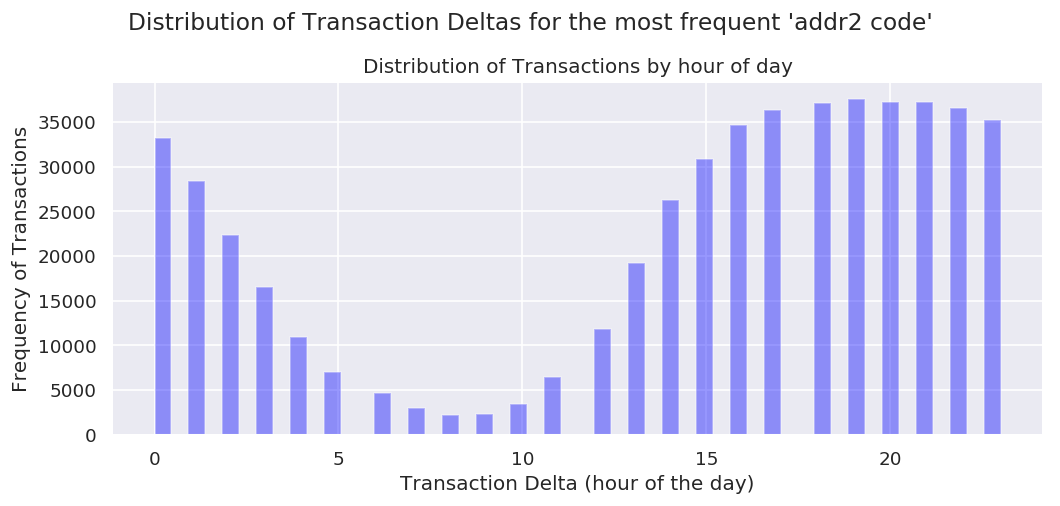

In [0]:
plt.figure(figsize=(9, 4), dpi=120)
plt.suptitle('Distribution of Transaction Deltas for the most frequent \'addr2 code\'', size=14, y = 1.05)

plt.title('Distribution of Transactions by hour of day')
ax = sns.distplot(train_raw_filtered_pt2['Transaction_hrOfDay'], kde=False, color='blue')
ax.set(xlabel = 'Transaction Delta (hour of the day)')
ax.set(ylabel = 'Frequency of Transactions')

plt.tight_layout()
plt.show()

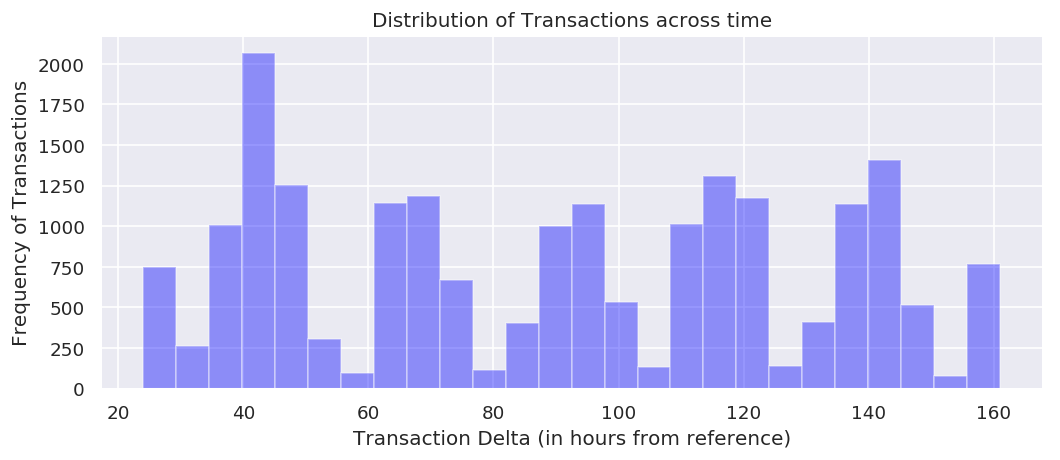

In [0]:
plt.figure(figsize=(9, 4), dpi=120)

plt.title('Distribution of Transactions across time')
ax = sns.distplot(train_raw_filtered_pt2['TransactionDT_hr'].head(20000), kde=False, color='blue')
ax.set(xlabel = 'Transaction Delta (in hours from reference)')
ax.set(ylabel = 'Frequency of Transactions')

plt.tight_layout()
plt.show()

### Explanation of Observation
From both the plots of transactions in region-code 87 (the most frequent addr2-code) above, it is apparent that **there is a recurring pattern in the transaction frequency across time**. These plots were expected to be periodic - because transactions are more common during a part of the day (daylight hours) - and so they are.

The first plot shows the periodicity over a single day as computed from the whole dataset, with the curve picking up after the 10th hour and dying off by the 5th (the following day). The hour number here is relative to the unknown reference point as in the data.

The second plot shows the periodicity over time for the first 20000 transactions (limited for visualization convenience) in region-code 87. As was expected and is clearly visible, there is a regular rise and fall in number of transactions - possibly pointing to which is the day-time (and therefore the time-zone) for region-code 87 - **approximately about 15 hours ahead of the reference point**. 

## Part 3 - Product Code

In [0]:
train_raw_filtered_pt3 = train_raw_filtered[[target_col, 'ProductCD', 'TransactionAmt']]
train_raw_filtered_pt3_summarized = train_raw_filtered_pt3.groupby('ProductCD').mean()
train_raw_filtered_pt3_summarized = train_raw_filtered_pt3_summarized.rename(columns={'TransactionAmt':'MeanTransactionAmt'})
del train_raw_filtered_pt3_summarized[target_col]
train_raw_filtered_pt3_summarized

,MeanTransactionAmt
ProductCD,
C,42.872353
H,73.170058
R,168.306188
S,60.269487
W,153.158554


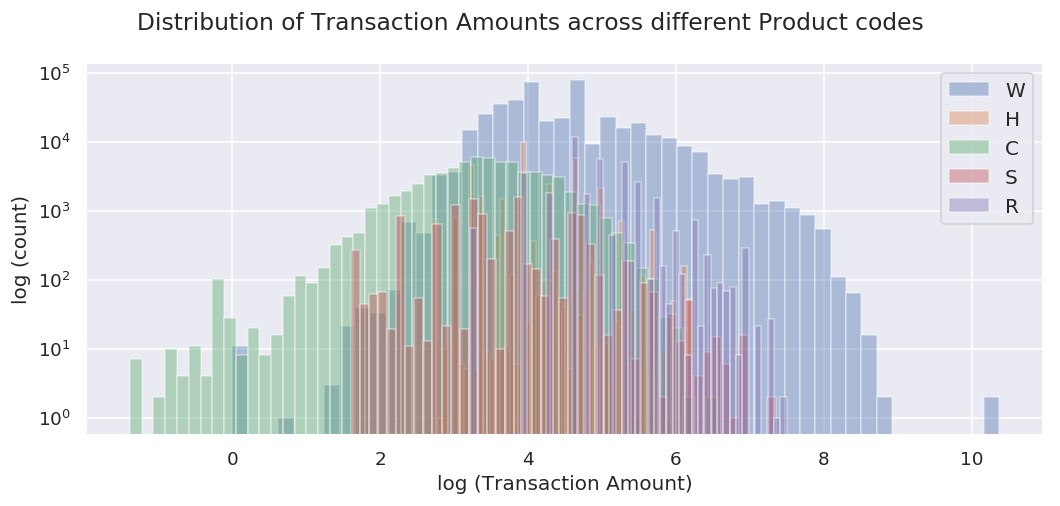

In [0]:
plt.figure(figsize=(9, 4), dpi=120)

for productCode in train_raw_filtered_pt3['ProductCD'].unique():
  ax = sns.distplot(np.log(train_raw_filtered_pt3[train_raw_filtered_pt3['ProductCD'] == productCode]['TransactionAmt']), label=productCode, kde=False)
  ax.set(yscale='log')

plt.legend(prop={'size': 12})
plt.suptitle('Distribution of Transaction Amounts across different Product codes', size=14, y = 1.05)
plt.xlabel('log (Transaction Amount)')
plt.ylabel('log (count)')

plt.tight_layout()
plt.show()

### Analysis:

From both the summarized statistics as well as the plot of the distributions of Transaction amounts across the different Product-codes, it can be concluded that

*   **Product-Code W are the most expensive items**
*   **Product-Code C are the cheapest items**

### Justification:
The summary shows that mean transaction amounts of 'W' products is the highest and that of 'C' products is the lowest. This however is not conclusive enough, as mean is susceptible to outliers in the distributions. On the other hand, median or mode would not give the info about the general costs of these products (as they are count-specific central tendencies, and none of these averages measure the spread/dispersion of the transaction amounts).

  For this reason, the distributions of Transaction-amounts are plotted for each product-code (in the same chart for comparison). Log-scales are taken for easier comparisons. It reveals 'C' products as a whole are to the leftmost (lower transaction amounts) and the 'W' are to the rightmost (higher transaction amounts, with even some very high amounts as outliers). Hence this bears conclusive evidence that **'C' products are generally cheapest and 'W' products are generally most expensive.**

## Part 4 - Correlation Coefficient

In [0]:
train_raw_filtered_pt4 = train_raw_filtered[[target_col, 'TransactionDT', 'TransactionAmt']]
train_raw_filtered_pt4['hrOfDay'] = (train_raw_filtered_pt4['TransactionDT'] // 3600 ) % 24
train_raw_filtered_pt4.head()

,isFraud,TransactionDT,TransactionAmt,hrOfDay
0,0,86400,68.5,0
1,0,86401,29.0,0
2,0,86469,59.0,0
3,0,86499,50.0,0
4,0,86506,50.0,0


In [0]:
g = train_raw_filtered_pt4.groupby('hrOfDay')
train_raw_filtered_pt4_summarized = g.sum()[['TransactionAmt']] / 1000000
train_raw_filtered_pt4_summarized.rename(columns={'TransactionAmt':'TotalTransactionAmt'}, inplace=True)
train_raw_filtered_pt4_summarized['MeanTransactionAmt'] = g.mean()[['TransactionAmt']]
train_raw_filtered_pt4_summarized.head()

,TotalTransactionAmt,MeanTransactionAmt
hrOfDay,,
0,4.660496,123.309863
1,3.805385,116.028447
2,2.976132,111.332197
3,2.217529,106.601731
4,1.527839,102.961020


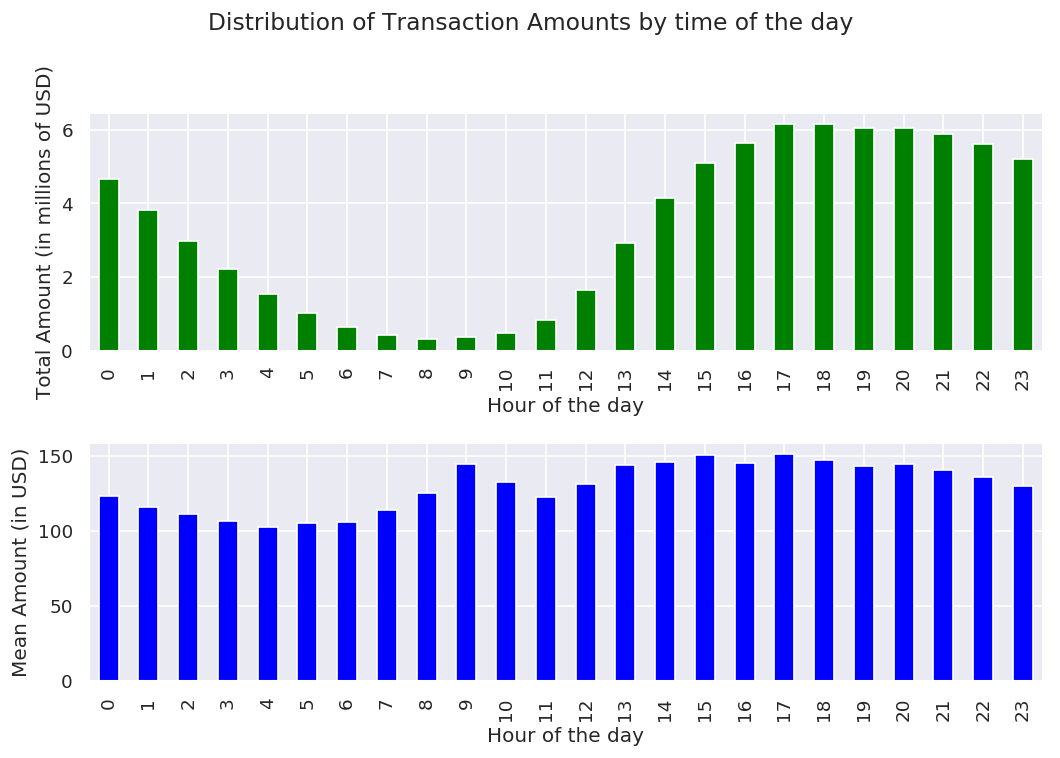

In [0]:
fig = plt.figure(figsize=(9, 6), dpi=120)
plt.suptitle('Distribution of Transaction Amounts by time of the day', size=14, y=1.05)

ax = fig.add_subplot(211)
train_raw_filtered_pt4_summarized['TotalTransactionAmt'].plot(kind='bar',color='green',ax=ax)
ax.set(xlabel = 'Hour of the day')
ax.set(ylabel = 'Total Amount (in millions of USD)')

ax = fig.add_subplot(212)
train_raw_filtered_pt4_summarized['MeanTransactionAmt'].plot(kind='bar',color='blue',ax=ax)
ax.set(xlabel = 'Hour of the day')
ax.set(ylabel = 'Mean Amount (in USD)')

plt.tight_layout()
plt.show()

In [0]:
train_raw_filtered_pt4_summarized['hrOfDay'] = train_raw_filtered_pt4_summarized.index
train_raw_filtered_pt4_summarized.head()

,TotalTransactionAmt,MeanTransactionAmt,hrOfDay
hrOfDay,,,
0,4.660496,123.309863,0
1,3.805385,116.028447,1
2,2.976132,111.332197,2
3,2.217529,106.601731,3
4,1.527839,102.961020,4


In [0]:
corr_hrOfDay_totalAmt = train_raw_filtered_pt4_summarized['hrOfDay'].corr(train_raw_filtered_pt4_summarized['TotalTransactionAmt'], method='pearson')
print("Correlation Coefficient between Hour of the day and Total transaction amount:", round(corr_hrOfDay_totalAmt, 2))
corr_hrOfDay_meanAmt = train_raw_filtered_pt4_summarized['hrOfDay'].corr(train_raw_filtered_pt4_summarized['MeanTransactionAmt'], method='pearson')
print("Correlation Coefficient between Hour of the day and Mean transaction amount:", round(corr_hrOfDay_meanAmt, 2))

Correlation Coefficient between Hour of the day and Total transaction amount: 0.64
Correlation Coefficient between Hour of the day and Mean transaction amount: 0.75


### Analysis

From both the plot above as well as the correlation coefficients it is apparent that there exists a **strong correlation** between the time of the day and both the total transaction amount (correlation-coeff: **0.64**) as well as the mean transaction amount (correlation-coeff: **0.75**).

**Note**: A word on Time-Zone corrections\
If we assume that addr2 codes correspond to geographically widely distributed regions (like countries), we should have adjusted time-zones to unify the time-of-day across all regions. However, we also note that in this dataset, about 90% of the data belongs to a single region only (code 87) and about 9% more are unknown leaving less than 1% for all other regions. Since these are very small fraction of the observations, the slight inaccuracy of not aligning their time-zones to a uniform should not impact the correlation all that much. Hence, this alignment has been omitted intentionally.


## Part 5 - Interesting Plot

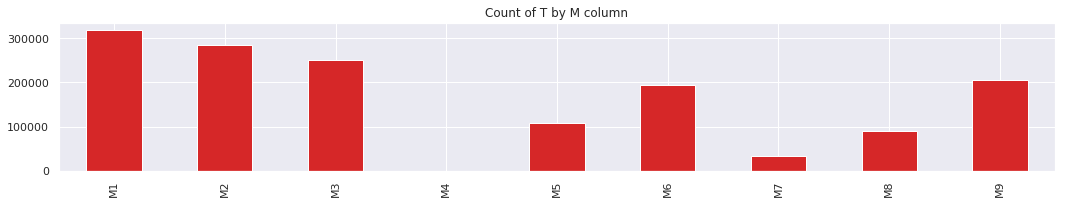

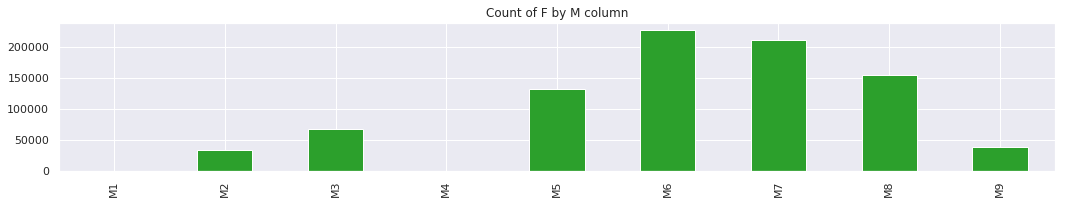

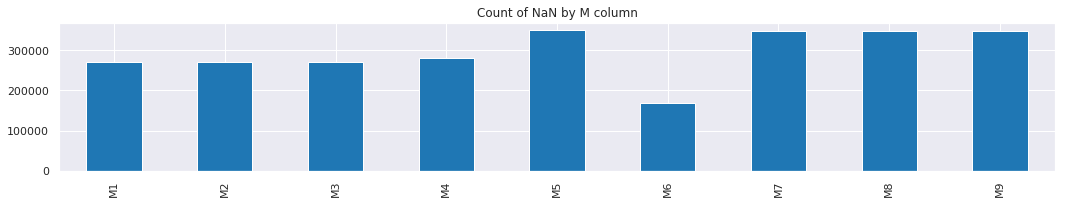

In [0]:
(train_tx[m_cols] == 'T').sum().plot(kind='bar', title='Count of T by M column', figsize=(15, 3), color=color_pal[3])
plt.tight_layout()
plt.show()

(train_tx[m_cols] == 'F').sum().plot(kind='bar', title='Count of F by M column', figsize=(15, 3), color=color_pal[2])
plt.tight_layout()
plt.show()

(train_tx[m_cols].isna()).sum().plot(kind='bar', title='Count of NaN by M column', figsize=(15, 3), color=color_pal[0])
plt.tight_layout()
plt.show()

### A correlation revealed

From the data description on Kaggle, the M-columns are match-based attributes and hence mostly contain booleans.\
It can be seen from this tri-plot that **for all or most of the fraudulent transactions, M1, M2 and/or M3 either matches or is unknown**. 

### Other interesting plots

In [0]:
train_raw['hr_of_day'] = (train_raw['TransactionDT'] // 3600) % 24

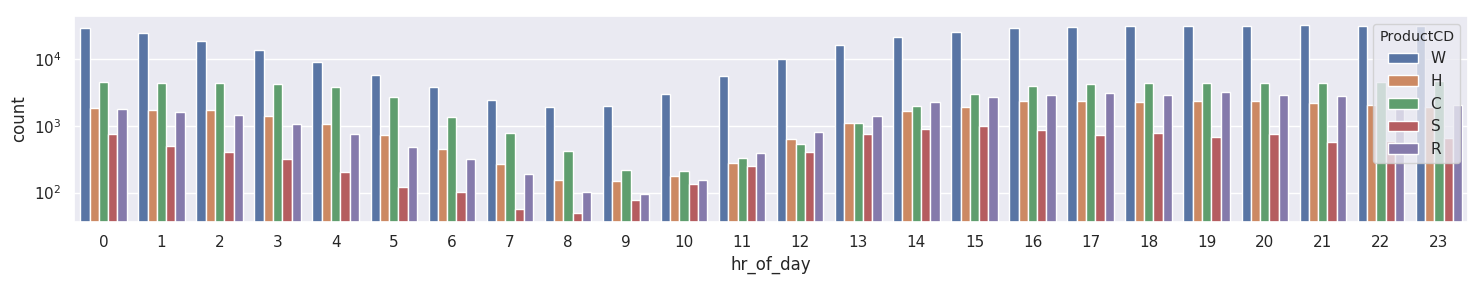

In [0]:
fig = plt.figure(figsize=(15, 3), dpi=100)
ax = sns.countplot(train_raw['hr_of_day'], hue=train_raw['ProductCD'])
ax.set_yscale('log')

plt.tight_layout()

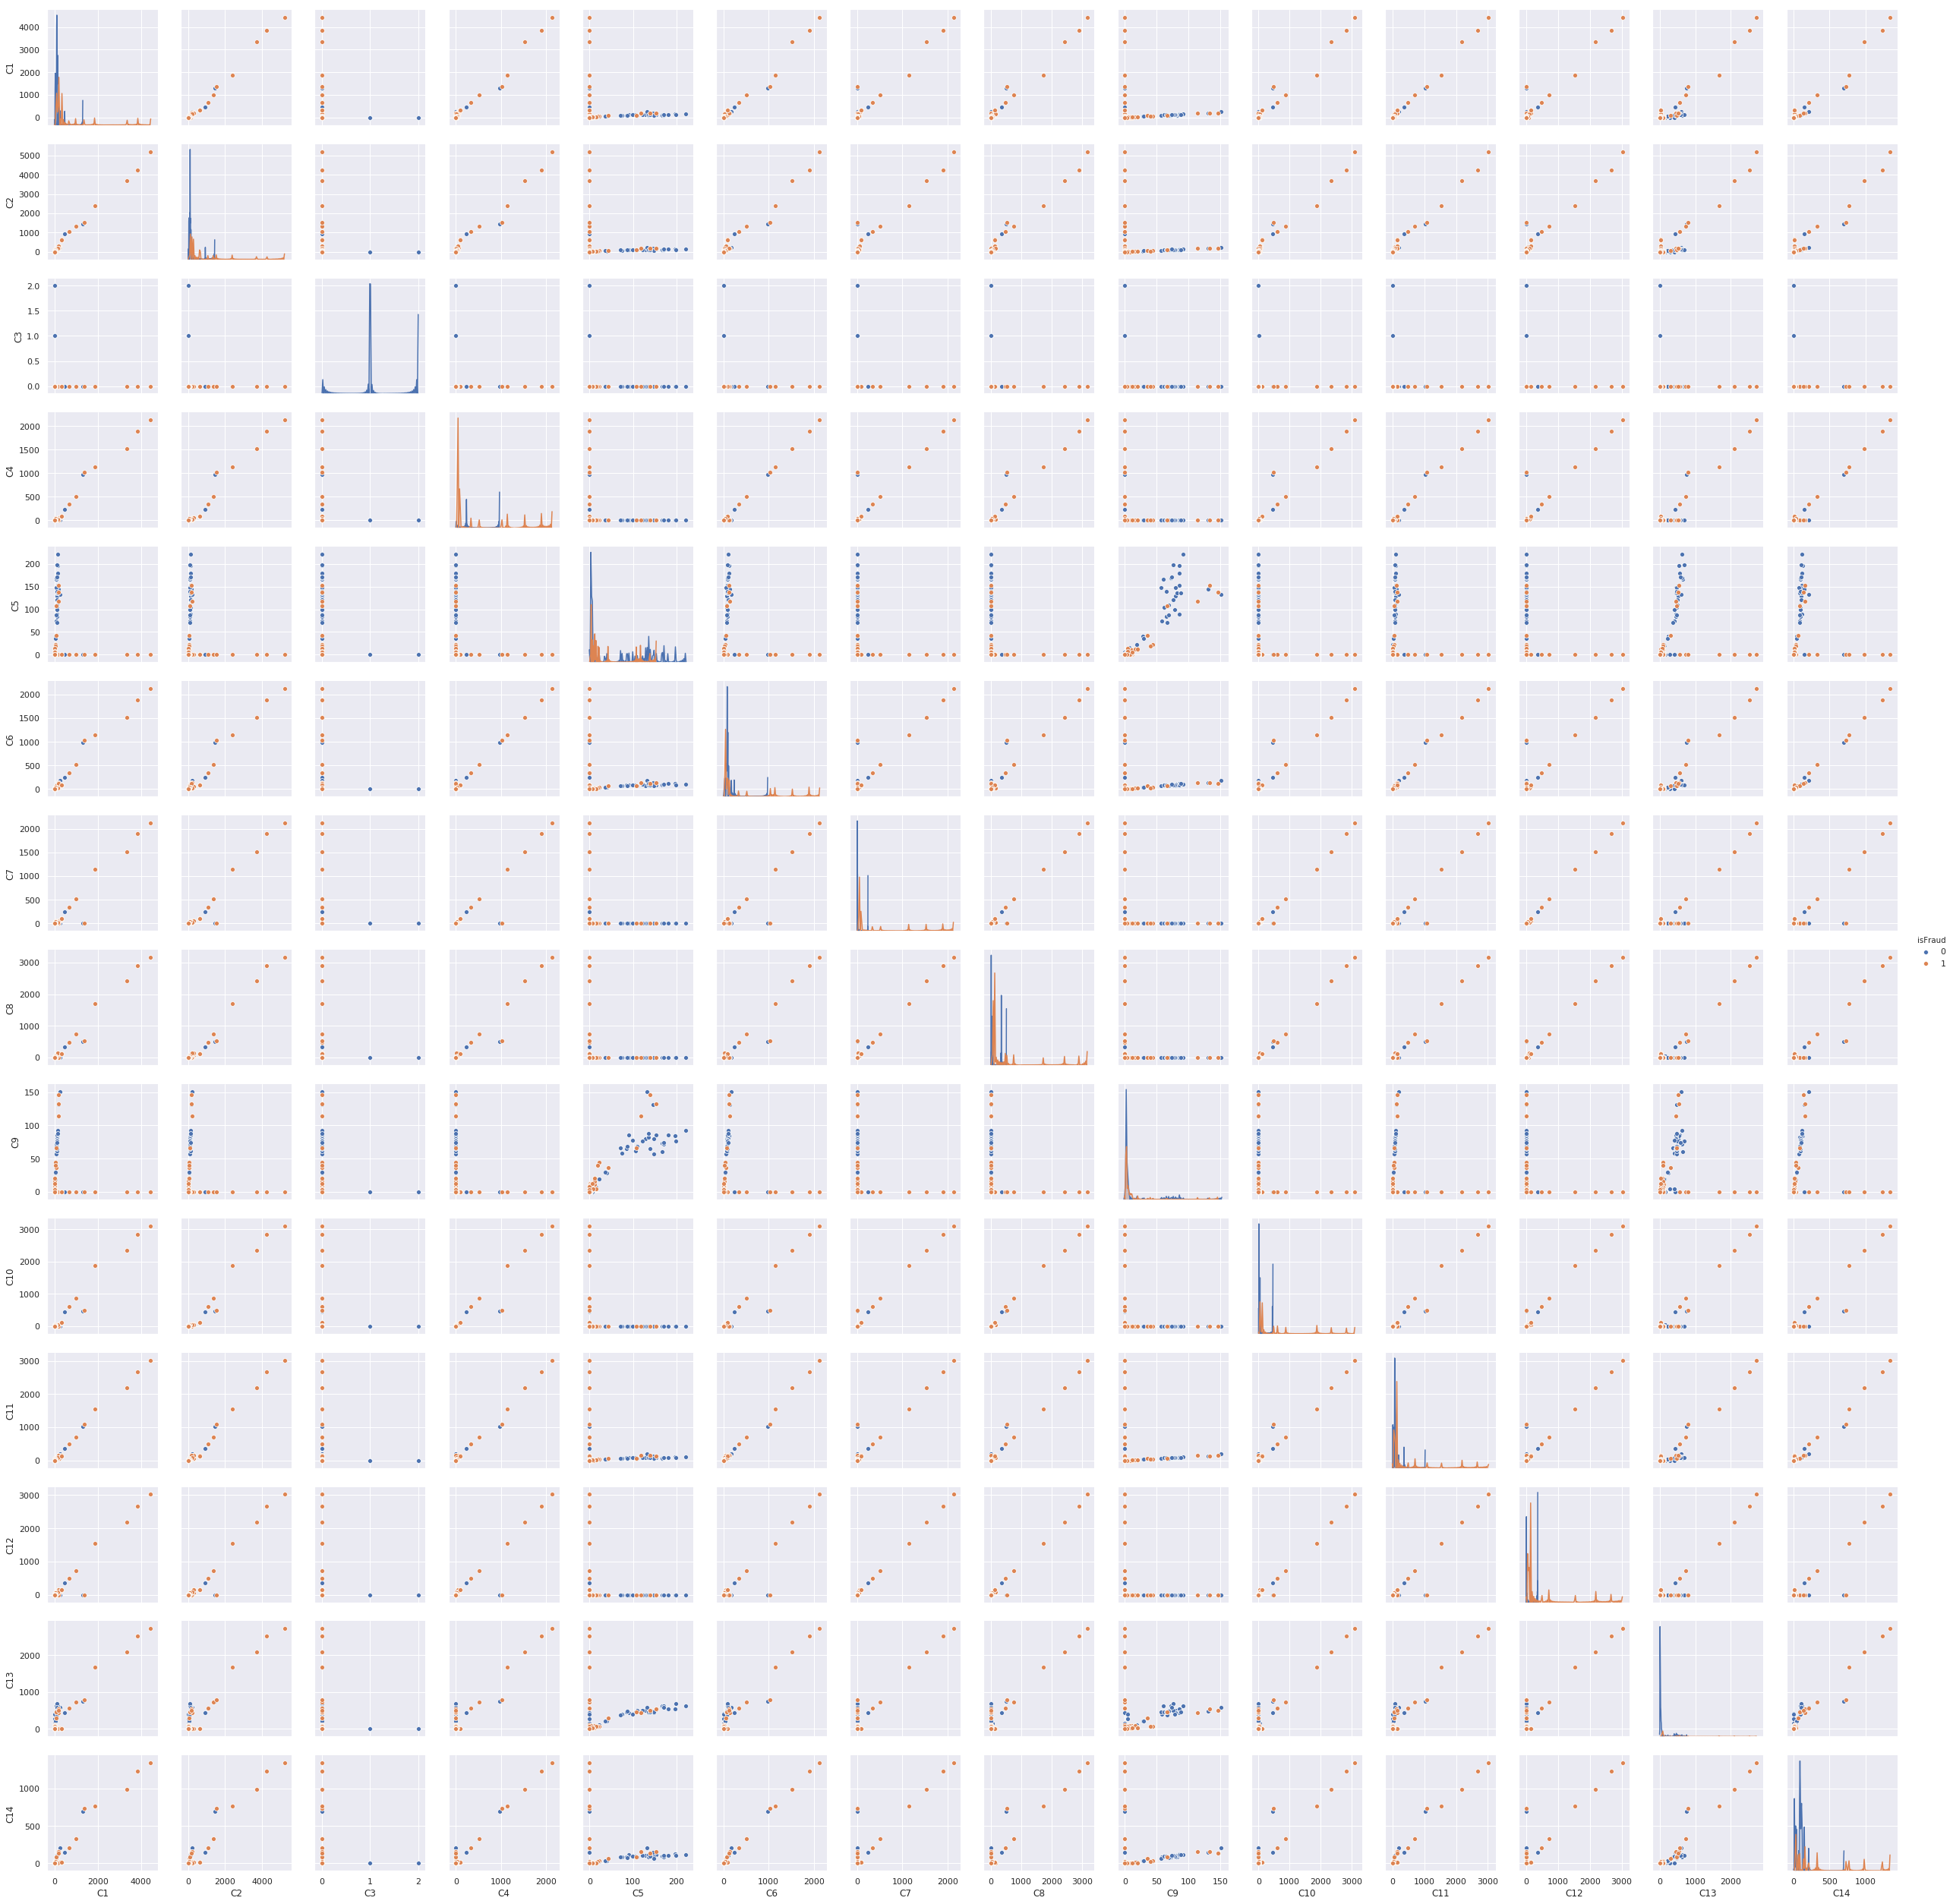

In [0]:
sampled_train_tx = pd.concat([train_tx.loc[train_tx['isFraud'] == 0].sample(500), 
                              train_tx.loc[train_tx['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train_tx, hue=target_col, vars=c_cols)
plt.show()

In [0]:
df = standardize_categorical_data(sampled_train_tx[card_cols], encoding='Label')
df[target_col] = sampled_train_tx[target_col]
df.head()

,card1,card2,card3,card4,card5,card6,isFraud
173919,347,138,10,4,7,1,0
1763,152,138,10,4,7,1,0
124312,202,6,6,4,23,1,0
85231,165,37,10,4,7,1,0
334223,211,52,6,4,12,1,0


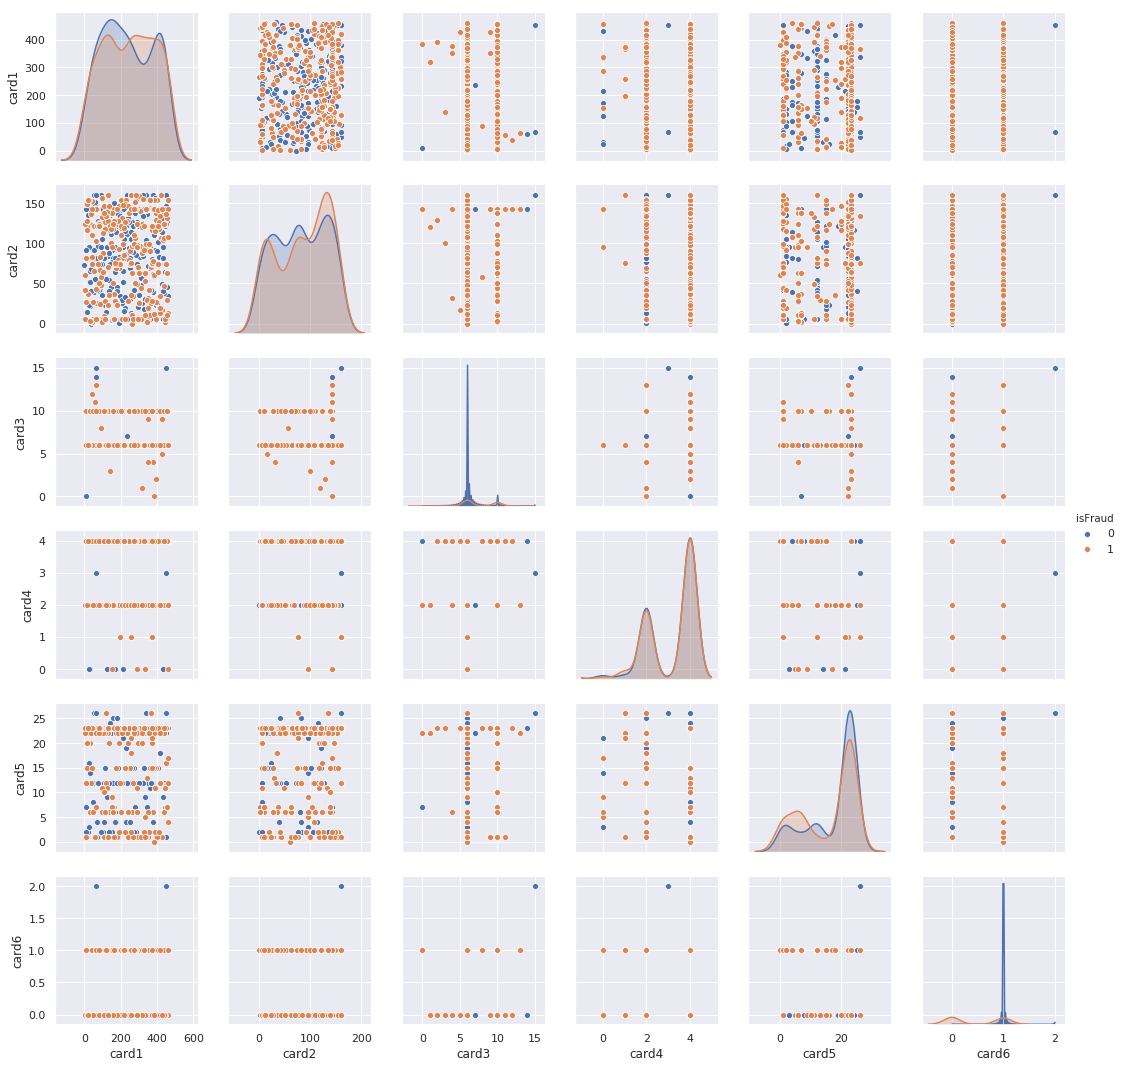

In [0]:
sns.pairplot(df, hue=target_col, vars=card_cols)
plt.show()

## Cleanup to free some memory

In [0]:
del train_tx
del train_identity
del test_tx
del test_identity

In [0]:
del train_raw_filtered
del train_positives
del train_negatives

In [0]:
del train_raw_filtered_tempDF
del train_positives_tempDF
del train_negatives_tempDF

## Part 6 - Prediction Model

### 6.1: Data Preparation

In [0]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pandas.api.types import CategoricalDtype

#### 6.1.1: Data Standardization

In [0]:
def prepare_categorical_data(data, encoding=None):
    df = pd.DataFrame()

    # Missing-value imputation - replace NaNs with a default string
    df = data.fillna("UNK")

    # Data-type standardization - convert all categorical cols to string data-types for encoding
    df = df.astype({col:'str' for col in data.columns if col in categorical_cols})

    # Preprocessing
    if encoding == 'Label':
        le = LabelEncoder()
      
    for col in data.columns:
        if col in categorical_cols:
            # Unify case for strings
            df[col] = df[col].str.lower()

            # For id_30 and id_31 cols - remove the version-numbers
            if col in ['id_30', 'id_31']:
                df[col] = df[col].str.replace(r'[^A-Za-z]', '', regex=True)

            # Encode categorical columns for using in the model
            if encoding == 'Label':
                df[col] = le.fit_transform(df[col])
            elif encoding == 'CategoricalDtype':
                catDtype = CategoricalDtype(categories=df[col].value_counts().index.values)
                df[col] = df[col].astype(catDtype).cat.codes.values
            elif encoding:
                print("Invalid Encoding")
                return pd.DataFrame()

    return df

def prepare_numeric_data(data, data_stats, \
                         transform_cols=[], scaling_method='std', \
                         impute_method='fill', na_fill_value=0):
    # Data-type standardization - convert all numeric cols to float data-types for processing
    # move this one to reduce_memory() later
    df = data.astype({col:data_stats.at['Types',col] for col in data.columns if col in numeric_cols})

    # Preprocessing - Standardize values
    if transform_cols:
        if scaling_method == 'std':
            scaler = StandardScaler()
#         elif scaling_method == 'min_max':
#             scaler = MinMaxScaler()
    df[transform_cols] = pd.DataFrame(scaler.fit_transform(df[transform_cols]), columns=transform_cols)

    # Missing-value imputation
    if impute_method == 'fill':
        df.fillna(na_fill_value, inplace=True)

    return df

In [0]:
def extract_and_add_new_features(data, new_feature_cols=None):
    if not new_feature_cols:
        return data
    
    if 'TransactionDT_hrs' in new_feature_cols:
        data['TransactionDT_hrs'] = (data['TransactionDT'] // 3600)
        extracted_features.append('TransactionDT_hrs')
    
    if 'hr_of_day' in new_feature_cols:
        data['hr_of_day'] = (data['TransactionDT'] // 3600) % 24
        extracted_features.append('hr_of_day')
    
    if 'nMissing' in new_feature_cols:
        data['nMissing'] = data.isna().sum(axis=1)
        extracted_features.append('nMissing')
    
    return data

In [0]:
def prepare_data_for_model_v1(data, data_stats, append_target=True):
    df1 = prepare_categorical_data(data[categorical_cols], encoding='Label')
    df2 = prepare_numeric_data(data[numeric_cols], data_stats, na_fill_value=0)

    if append_target:
        df = pd.concat([data[target_col],df1,df2], axis=1)
    else:
        df = pd.concat([df1,df2], axis=1)
        
    del df1
    del df2

    df['TransactionDT_hrs'] = (data['TransactionDT'] // 3600)
    df['hr_of_day'] = (data['TransactionDT'] // 3600) % 24

    return df

In [0]:
def prepare_data_for_model_v2(data, data_stats, append_target=True):
    df1 = prepare_categorical_data(data[categorical_cols], encoding='CategoricalDtype')
    df2 = prepare_numeric_data(data[numeric_cols], data_stats, na_fill_value=-9999)

    if append_target:
        df = pd.concat([data[PK],data[target_col],df1,df2], axis=1)
    else:
        df = pd.concat([data[PK],df1,df2], axis=1)
        
    del df1
    del df2

    df['TransactionDT_hrs'] = (data['TransactionDT'] // 3600)
    df['hr_of_day'] = (data['TransactionDT'] // 3600) % 24

    return df

In [0]:
def prepare_data_for_model_v3(data, data_stats, extractFeatures=None, \
                              std_cat_cols=[], cat_encoding=None, \
                              num_cols=[], std_num_cols=[], num_impute_method='fill', na_fill_value=0, \
                              std_dt_cols=[], \
                              drop_cols=[], append_target=True):
    if extractFeatures:
        data = extract_and_add_new_features(data, extractFeatures)
    if std_cat_cols:
        df1 = prepare_categorical_data(pd.DataFrame(data[std_cat_cols]), encoding=cat_encoding)
    if std_num_cols:
        df2 = prepare_numeric_data(pd.DataFrame(data[num_cols]), data_stats, \
                                   transform_cols=std_num_cols, \
                                   impute_method=num_impute_method, na_fill_value=na_fill_value)
    
    df = pd.concat([df1,df2], axis=1)
    other_cols = [col for col in data.columns \
                  if col not in std_cat_cols + num_cols + std_dt_cols + drop_cols + [PK, target_col]]
    df = pd.concat([df,data[other_cols]], axis=1)
    if append_target:
        df = pd.concat([data[target_col],df], axis=1)
        
    del df1
    del df2

    return df

### 6.2: Model Development 

In [0]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score

In [0]:
def make_predictions(model, test_data, model_name='other', model_no=1, prediction_no=1, \
                     show_predictions=False, save=True):
    
    if model_name == 'LGBM':
        y_test = model.predict(test_data, num_iteration=model.best_iteration)
    else:
        y_test = model.predict_proba(test_data)[:,1]
        
    df = pd.DataFrame()
    df[PK] = test_raw[PK]
    df[target_col] = y_test

    if show_predictions:
        print(df.head())
        print(df.tail())
    if save:    
        outfile = './data/submission_m' + str(model_no).zfill(2) + '_v' + str(prediction_no).zfill(2) + '.csv'
        df.to_csv(outfile, index=False)

### 6.2.1: Model 1 - Logistic Regression

#### 6.2.1.1: Feature Preparation

In [0]:
features = categorical_cols + numeric_cols

In [0]:
train_data = prepare_data_for_model_v1(train_raw, train_data_stats)
train_data.head()

In [0]:
X_train, X_cv, y_train, y_cv = train_test_split(train_data, train_raw[target_col], test_size=0.2)

#### 6.2.1.2: Model Training & Evaluation

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
true_frac = 0.03
class_weights = { 0:1/(2*(1 - true_frac)), 1:1/(2*true_frac) }
clf = LogisticRegression(solver='lbfgs', n_jobs=-1)

In [0]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_preds = clf.predict(X_cv)
y_preds

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
np.count_nonzero(y_preds)

0

In [0]:
precision, recall, thresholds = precision_recall_curve(y_cv, y_preds)

In [0]:
precision, recall

(array([0.03552681, 1.        ]), array([1., 0.]))

In [0]:
auroc = roc_auc_score(y_cv, y_preds)
auroc

0.5

#### 6.2.1.3: Prediction

In [0]:
# Prepare Test-data X_test
test_data = prepare_data_for_model_v1(test_raw, test_data_stats)
test_data.head()

,TransactionID,card1,card2,card3,card4,card5,card6,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,...,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,3663549,353,11,45,4,94,3,1,1,0,3,2,0,1,1,1,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,47,0,5,390,0,2,...,-0.018518,-0.091377,-0.224356,-0.221224,-0.231080,-0.018707,-0.028707,-0.024777,-0.027623,-0.030916,-0.024732,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,3663550,8860,11,45,4,94,3,1,0,0,0,2,0,2,2,2,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,47,0,5,390,0,2,...,-0.018518,0.073274,-0.224356,-0.221224,-0.231080,-0.018707,-0.028707,-0.024777,-0.027623,-0.030916,-0.024732,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,3663551,9014,470,45,4,94,3,1,1,0,0,0,0,0,0,0,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,47,0,5,390,0,2,...,-0.018518,-0.091377,-0.224356,-0.221224,-0.231080,-0.018707,-0.028707,-0.024777,-0.027623,0.142690,-0.024732,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,3663552,838,258,45,4,53,3,1,1,1,3,2,1,2,2,2,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,47,0,5,390,0,2,...,-0.018518,-0.091377,2.760352,1.223316,2.211428,-0.018707,-0.028707,-0.024777,-0.027623,-0.030916,-0.024732,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,3663553,6719,350,45,3,12,3,1,1,1,3,2,0,0,1,1,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,47,0,5,390,0,2,...,0.225638,0.053922,0.493457,0.718745,0.356336,-0.018707,-0.028707,-0.024777,-0.027623,-0.030916,-0.024732,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [0]:
make_predictions(clf, test_data, model_no=1, prediction_no=2, show_predictions=True, save=True)

(506691, 1) (506691, 433) 506691
   TransactionID   isFraud
0        3663549  0.014724
1        3663550  0.016348
2        3663551  0.016121
3        3663552  0.014656
4        3663553  0.015703
        TransactionID   isFraud
506686        4170235  0.008083
506687        4170236  0.031168
506688        4170237  0.008029
506689        4170238  0.007999
506690        4170239  0.062764


#### 6.2.1.4 - Cleanup to reclaim memory

In [0]:
del X_train
del X_cv
del Y_train
del Y_cv

del train_data
del test_data

del y_preds

### 6.2.2: Model 2 - xgboost

In [0]:
import xgboost as xgb

#### 6.2.2.1: Feature Preparation

In [25]:
extracted_features = ['hr_of_day', 'nMissing']
features = list(set(categorical_cols + numeric_cols + extracted_features))
print(len(features))

433


In [28]:
train_data = prepare_data_for_model_v3(train_raw, train_data_stats, \
                                       extractFeatures=extracted_features, \
                                       std_cat_cols=categorical_cols, cat_encoding='Label', \
                                       num_cols=numeric_cols, std_num_cols=['TransactionAmt'], \
                                       drop_cols=['TransactionDT'], append_target=False)
train_data.head()

,card1,card2,card3,card4,card5,card6,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,hr_of_day,nMissing
0,3417,500,42,1,38,1,1,1,1,2,0,1,2,2,2,2,54,25,2,2,104,18,522,394,490,25,3,12,341,95,2,2,2,7,55,4,260,4,2,2,...,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,234
1,7922,303,42,2,2,1,2,2,2,0,1,1,2,2,2,2,54,25,2,2,104,18,522,394,490,25,3,12,341,95,2,2,2,7,55,4,260,4,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,230
2,9383,389,42,4,58,2,1,1,1,0,0,0,0,0,0,2,54,25,2,2,104,18,522,394,490,25,3,12,341,95,2,2,2,7,55,4,260,4,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,211
3,6991,466,42,2,14,2,2,2,2,0,1,0,2,2,2,2,54,25,2,2,104,18,522,394,490,25,3,12,341,95,2,2,2,7,55,4,260,4,2,2,...,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,227
4,9262,413,42,2,2,1,2,2,2,3,2,2,2,2,2,1,54,7,1,1,59,18,400,32,490,25,3,12,341,95,2,1,1,0,48,3,164,3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0,137


#### 6.2.2.2: Model Training & Evaluation

In [0]:
positive_class_wt = (train_raw[target_col]==0).sum() / (train_raw[target_col]==1).sum() / 5

In [0]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

scores = []
i = 0
for train_index, test_index in kfold.split(train_data):
    print("Starting iteration:", i+1)
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_jobs=-1, scale_pos_weight=positive_class_wt)
    
    X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_test = train_raw[target_col].iloc[train_index], train_raw[target_col].iloc[test_index]
    
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    scores.append({'matrix':confusion_matrix(y_test, y_pred),\
                   'auc':roc_auc_score(y_test, y_pred)})
    
    print("Completed iteration:", i+1)
    print(scores[-1])
    
    del X_train, X_test, y_train, y_test
    del xgb_model
    i += 1

Starting iteration: 1
Completed iteration: 1
{'matrix': array([[189582,    268],
       [  4963,   2034]]), 'auc': 0.6446421859038952}
Starting iteration: 2
Completed iteration: 2
{'matrix': array([[189722,    252],
       [  4923,   1950]]), 'auc': 0.6411962013667454}
Starting iteration: 3
Completed iteration: 3
{'matrix': array([[189798,    255],
       [  4878,   1915]]), 'auc': 0.6402830576607758}


In [0]:
print(scores)

[{'matrix': array([[189582,    268],
       [  4963,   2034]]), 'auc': 0.6446421859038952}, {'matrix': array([[189722,    252],
       [  4923,   1950]]), 'auc': 0.6411962013667454}, {'matrix': array([[189798,    255],
       [  4878,   1915]]), 'auc': 0.6402830576607758}]


In [0]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_jobs=-1, scale_pos_weight=positive_class_wt)

In [32]:
xgb_model.fit(train_data, train_raw[target_col])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.515917340173257,
              seed=None, silent=None, subsample=1, verbosity=1)

#### 6.2.2.3: Prediction

In [29]:
test_data = prepare_data_for_model_v3(test_raw, test_data_stats, \
                                      extractFeatures=extracted_features, \
                                      std_cat_cols=categorical_cols, cat_encoding='Label', \
                                      num_cols=numeric_cols, std_num_cols=['TransactionAmt'], \
                                      drop_cols=['TransactionDT'], append_target=False)
test_data.head()

,card1,card2,card3,card4,card5,card6,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,hr_of_day,nMissing
0,353,11,45,4,94,2,1,1,0,3,2,0,1,1,1,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,2,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,210
1,8860,11,45,4,94,2,1,0,0,0,2,0,2,2,2,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,2,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,212
2,9014,470,45,4,94,2,1,1,0,0,0,0,0,0,0,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,2,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,208
3,838,258,45,4,53,2,1,1,1,3,2,1,2,2,2,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,2,...,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,213
4,6719,350,45,2,12,2,1,1,1,3,2,0,0,1,1,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,2,...,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,210


In [33]:
prediction_no=3
make_predictions(xgb_model, test_data, model_no=2, prediction_no=prediction_no, show_predictions=True)

   TransactionID   isFraud
0        3663549  0.030956
1        3663550  0.052736
2        3663551  0.085716
3        3663552  0.019762
4        3663553  0.049280
        TransactionID   isFraud
506686        4170235  0.091606
506687        4170236  0.102591
506688        4170237  0.061204
506689        4170238  0.072645
506690        4170239  0.085024


#### 6.2.2.4: Cleanup

In [0]:
model_name = 'xgb' + str(prediction_no).zfill(3) + '.model'
xgb_model.save_model('./models/' + model_name)

In [0]:
del train_data
del test_data

del xgb_model

### 6.2.3: Model 3 - Catboost

In [0]:
pip install catboost

In [0]:
from catboost import Pool, CatBoostClassifier, cv

#### 6.2.3.1: Feature Preparation

In [23]:
extracted_features = ['hr_of_day', 'nMissing']
features = list(set(categorical_cols + numeric_cols + extracted_features))
print(len(features))

433


In [26]:
X_train = prepare_data_for_model_v3(train_raw, train_data_stats, \
                                    extractFeatures=extracted_features, \
                                    std_cat_cols=categorical_cols, \
                                    num_cols=numeric_cols, std_num_cols=['TransactionAmt'], \
                                    drop_cols=['TransactionDT'], append_target=False)
X_train.head()

,card1,card2,card3,card4,card5,card6,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,hr_of_day,nMissing
0,13926,unk,150.0,discover,142.0,credit,t,t,t,m2,f,t,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,...,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,234
1,2755,404.0,150.0,mastercard,102.0,credit,unk,unk,unk,m0,t,t,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,230
2,4663,490.0,150.0,visa,166.0,debit,t,t,t,m0,f,f,f,f,f,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,211
3,18132,567.0,150.0,mastercard,117.0,debit,unk,unk,unk,m0,t,f,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,...,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,227
4,4497,514.0,150.0,mastercard,102.0,credit,unk,unk,unk,unk,unk,unk,unk,unk,unk,notfound,unk,-480.0,new,notfound,166.0,unk,542.0,144.0,unk,unk,unk,unk,unk,unk,unk,new,notfound,android,samsungbrowser,32.0,2220x1080,match_status:2,t,f,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0,137


#### 6.2.3.2: Model Training & Evaluation

In [0]:
train_pool = Pool(data=X_train[features], label=train_raw[target_col], cat_features=categorical_cols)

In [0]:
positive_class_wt = (train_raw[target_col]==0).sum() / (train_raw[target_col]==1).sum() / 5

In [0]:
model_params = {
    'iterations': 100,
    'custom_metric': 'AUC',
    'loss_function': 'Logloss',
    'scale_pos_weight': positive_class_wt
}

In [0]:
crossValidation_report = cv(train_pool, model_params, fold_count=3, plot=True, verbose=False)

In [38]:
crossValidation_report.tail()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
95,95,0.271769,0.001547,0.274242,0.000424,0.888493,0.000144
96,96,0.271370,0.001540,0.273858,0.000428,0.888681,0.000196
97,97,0.271035,0.001517,0.273531,0.000434,0.888832,0.000190
98,98,0.270723,0.001489,0.273226,0.000442,0.888996,0.000148
99,99,0.270349,0.001377,0.272868,0.000494,0.889153,0.000208


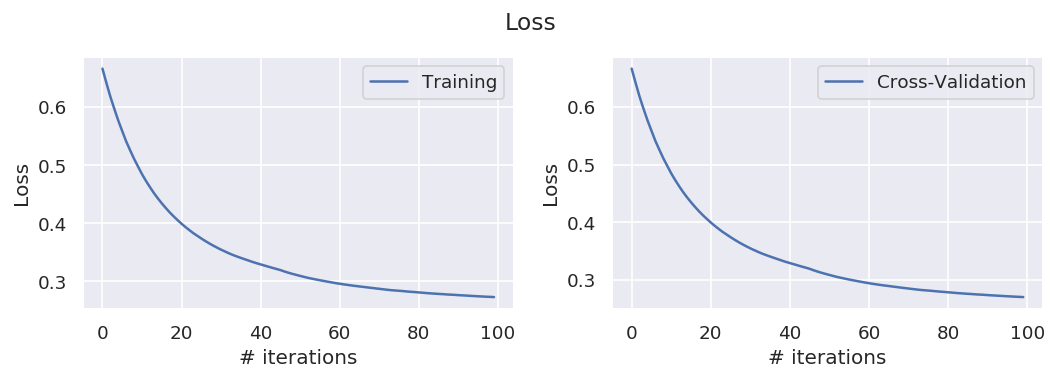

In [39]:
fig = plt.figure(figsize=(9,3), dpi=120)
plt.suptitle("Loss", size = 14, y = 1.05)

plt.subplot(1,2,1)
plt.plot(crossValidation_report['train-Logloss-mean'], label='Training')
plt.xlabel('# iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(crossValidation_report['test-Logloss-mean'], label='Cross-Validation')
plt.xlabel('# iterations')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [0]:
# Since both losses continue to decrease, we can increase number of iterations
model_params['iterations'] += 20

In [0]:
model = CatBoostClassifier(**model_params)

In [46]:
model.fit(train_pool, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### 6.2.3.3: Prediction

In [47]:
# Prepare the test-data
X_test = prepare_data_for_model_v3(test_raw, test_data_stats, \
                                    extractFeatures=extracted_features, \
                                    std_cat_cols=categorical_cols, \
                                    num_cols=numeric_cols, std_num_cols=['TransactionAmt'], \
                                    drop_cols=['TransactionDT'], append_target=False)
X_test.head()

,card1,card2,card3,card4,card5,card6,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,hr_of_day,nMissing
0,10409,111.0,150.0,visa,226.0,debit,t,t,f,unk,unk,f,t,t,t,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,210
1,4272,111.0,150.0,visa,226.0,debit,t,f,f,m0,unk,f,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,212
2,4476,574.0,150.0,visa,226.0,debit,t,t,f,m0,f,f,f,f,f,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,208
3,10989,360.0,150.0,visa,166.0,debit,t,t,t,unk,unk,t,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,...,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,213
4,18018,452.0,150.0,mastercard,117.0,debit,t,t,t,unk,unk,f,f,t,t,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,unk,...,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,210


In [0]:
test_pool = Pool(data=X_test[features], cat_features=categorical_cols)

In [50]:
# Predict
prediction_no=2
make_predictions(model, test_pool, model_no=3, prediction_no=prediction_no, show_predictions=True)

   TransactionID   isFraud
0        3663549  0.015880
1        3663550  0.030757
2        3663551  0.018506
3        3663552  0.033028
4        3663553  0.021402
        TransactionID   isFraud
506686        4170235  0.094084
506687        4170236  0.021171
506688        4170237  0.033005
506689        4170238  0.040225
506690        4170239  0.030094


#### 6.2.3.4: Save and Cleanup

In [0]:
model_name = 'catboost' + str(prediction_no).zfill(3) + '.model'
model.save_model('./models/' + model_name)

In [0]:
del X_train
del train_pool

del X_test
del test_pool

del model

### 6.2.4: Model 4 - LGBM

In [0]:
import lightgbm as lgb

In [0]:
extracted_features = ['hr_of_day', 'nMissing']
features = list(set(categorical_cols + numeric_cols + extracted_features))
print(len(features))

#### 6.2.4.2: Model Training & Evaluation

In [0]:
train_data = prepare_data_for_model_v1(train_raw, train_data_stats, append_target=True)
train_data.head()

,TransactionID,isFraud,card1,card2,card3,card4,card5,card6,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,TransactionDT_hrs,hr_of_day
0,2987000,0,3417,500,42,1,38,1,1,1,1,2,0,1,2,2,2,2,54,25,2,2,104,18,522,394,490,25,3,12,341,95,2,2,2,7,55,4,260,4,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.032815,-0.058050,-0.055288,-0.088856,-0.074143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,24,0
1,2987001,0,7922,303,42,2,2,1,2,2,2,0,1,1,2,2,2,2,54,25,2,2,104,18,522,394,490,25,3,12,341,95,2,2,2,7,55,4,260,4,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,24,0
2,2987002,0,9383,389,42,4,58,2,1,1,1,0,0,0,0,0,0,2,54,25,2,2,104,18,522,394,490,25,3,12,341,95,2,2,2,7,55,4,260,4,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,24,0
3,2987003,0,6991,466,42,2,14,2,2,2,2,0,1,0,2,2,2,2,54,25,2,2,104,18,522,394,490,25,3,12,341,95,2,2,2,7,55,4,260,4,...,-0.222636,-0.249507,-0.229407,-0.026351,0.290548,0.224765,-0.055288,-0.088856,-0.074143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,24,0
4,2987004,0,9262,413,42,2,2,1,2,2,2,3,2,2,2,2,2,1,54,7,1,1,59,18,400,32,490,25,3,12,341,95,2,1,1,0,48,3,164,3,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,-0.111033,-0.122764,-0.124744,-0.192152,-0.215438,-0.217417,-0.21314,-0.149714,-0.164104,-0.116088,-0.123176,-0.127534,-0.040216,-0.152633,-0.103909,-0.082803,-0.138043,-0.123568,0.70885,-0.650979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.225856,24,0


In [0]:
N_val = int(train_data.shape[0]*0.1)
train_data_cv = train_data.sort_values(by='TransactionDT_hrs').tail(N_val)
train_data_sample = train_data[~train_data.index.isin(train_data_cv.index)]

In [0]:
train_data_lgb = lgb.Dataset(
    data=train_data_sample[features], 
    label=train_data_sample[target_col],
    categorical_feature=categorical_cols,
    free_raw_data=False,
)

holdout_data_lgb = lgb.Dataset(
    data=train_data_cv[features], 
    label=train_data_cv[target_col],
    categorical_feature=categorical_cols,
    free_raw_data=False,
)

In [0]:
positive_class_wt = (train_data_sample[target_col]==0).sum() / (train_data_sample[target_col]==1).sum() / 2

In [0]:
lgb_model_params = {
    'num_leaves': 500,
    'min_data_in_leaf': 100,
    'max_depth': -1,
    'learning_rate': 0.01,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'scale_pos_weight': positive_class_wt,
    'early_stopping_rounds': 20
}

In [0]:
num_round = 100
bst = lgb.train(lgb_model_params, train_data_lgb, num_round, valid_sets=[holdout_data_lgb])

[1]	valid_0's auc: 0.866142
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.878529
[3]	valid_0's auc: 0.893967
[4]	valid_0's auc: 0.899657
[5]	valid_0's auc: 0.904158
[6]	valid_0's auc: 0.905477
[7]	valid_0's auc: 0.907964
[8]	valid_0's auc: 0.909066
[9]	valid_0's auc: 0.910746
[10]	valid_0's auc: 0.911644
[11]	valid_0's auc: 0.912277
[12]	valid_0's auc: 0.912226
[13]	valid_0's auc: 0.913302
[14]	valid_0's auc: 0.913557
[15]	valid_0's auc: 0.913796
[16]	valid_0's auc: 0.914502
[17]	valid_0's auc: 0.914335
[18]	valid_0's auc: 0.91562
[19]	valid_0's auc: 0.915871
[20]	valid_0's auc: 0.915847
[21]	valid_0's auc: 0.916227
[22]	valid_0's auc: 0.916322
[23]	valid_0's auc: 0.916908
[24]	valid_0's auc: 0.91717
[25]	valid_0's auc: 0.917734
[26]	valid_0's auc: 0.918209
[27]	valid_0's auc: 0.918425
[28]	valid_0's auc: 0.918497
[29]	valid_0's auc: 0.918808
[30]	valid_0's auc: 0.918874
[31]	valid_0's auc: 0.918812
[32]	valid_0's auc: 0.918922
[33]	valid_0's auc: 0

In [0]:
bst.best_score

defaultdict(dict, {'valid_0': {'auc': 0.9221656695596214}})

In [0]:
test_data = prepare_data_for_model_v1(test_raw, test_data_stats, append_target=False)
test_data.head()

,TransactionID,card1,card2,card3,card4,card5,card6,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,TransactionDT_hrs,hr_of_day
0,3663549,353,11,45,4,94,2,1,1,0,3,2,0,1,1,1,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,...,-0.224356,-0.221224,-0.231080,-0.018707,-0.028707,-0.024777,-0.027623,-0.030916,-0.024732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5112,0
1,3663550,8860,11,45,4,94,2,1,0,0,0,2,0,2,2,2,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,...,-0.224356,-0.221224,-0.231080,-0.018707,-0.028707,-0.024777,-0.027623,-0.030916,-0.024732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5112,0
2,3663551,9014,470,45,4,94,2,1,1,0,0,0,0,0,0,0,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,...,-0.224356,-0.221224,-0.231080,-0.018707,-0.028707,-0.024777,-0.027623,0.142690,-0.024732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5112,0
3,3663552,838,258,45,4,53,2,1,1,1,3,2,1,2,2,2,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,...,2.760352,1.223316,2.211428,-0.018707,-0.028707,-0.024777,-0.027623,-0.030916,-0.024732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5112,0
4,3663553,6719,350,45,2,12,2,1,1,1,3,2,0,0,1,1,2,27,27,2,2,103,17,502,436,443,26,3,15,309,94,2,2,2,7,25,5,390,2,2,...,0.493457,0.718745,0.356336,-0.018707,-0.028707,-0.024777,-0.027623,-0.030916,-0.024732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5112,0


In [0]:
prediction_no = 3
make_predictions(bst, test_data[features], model_name='LGBM', model_no=4, prediction_no=prediction_no, show_predictions=True)

   TransactionID   isFraud
0        3663549  0.016818
1        3663550  0.019627
2        3663551  0.025181
3        3663552  0.023713
4        3663553  0.021039
        TransactionID   isFraud
506686        4170235  0.370919
506687        4170236  0.215236
506688        4170237  0.123447
506689        4170238  0.201230
506690        4170239  0.232981


In [0]:
# Save model and Cleanup
model_file = 'lgbm' + str(prediction_no).zfill(3) + '.model'
bst.save_model('./models/'+model_file)

### Explanation

I followed the following steps to develop prediction models:\
1. First I **standardized the data** (differently according to their data types).\
   * **Categorical variables** - convert to str type, filled missing values with a "UNK" token, and encoded the values using either LabelEncoder or CategoricalDtypes
   * **Numeric variables** - convert to float or int type, standardized their values (z-score transformation), and filled the missing values with either 0 or -9999 (varied according to the model).
   * **Datetime deltas** - convert to hour of the day (reflecting time of the day instead of absolute time)
2. Next I developed 4 classification models - Logistic Regression, XGBoost, CatBoost and LGBM. In each case, I did the following:
   * Prepared the training data by standardizing as above, and other steps as necessary.
   * Split the data into training and cross-validation splits.
   * Trained the model.
   * Used the cross-validation data to evaluate the model.
   * Trained on the full training data (no cross-validation)
   * Passed the test-data through the same preparation pipeline as the training data.
   * Generated and saved predictions on the prepared/standardized test-data
   * Uploaded the results on Kaggle.
   
Some special case - columns 'id_30' and 'id_31' were parsed to remove all non-alphabetic characters. This was done to remove device OS version-numbers that they contained along with the OS name itself. Since the training and test data are from different time intervals, the version numbers in the test-data may not have been seen during the training (and besides that would increase the cardinality of the column unnecessarily). Strings were lowercased also.
   
I have made 6 submissions, of which the second XGBoost gave me the best Kaggle score (of 0.8745). I had used almost all the columns in the data (except the primary key - TransactionID). Interestingly however, the latter models CatBoost and LGBM had a much better AUC score during evaluation, but got a lower score on Kaggle Submission. :(

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/apalitsbu

Highest Rank: 5019

Score: 0.8745

Number of entries: 6

https://drive.google.com/open?id=1xlTX1IiHu887sk66z88qVldhVUEUrvgD